In [295]:
import anndata as ad
import scanpy as sc
from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy, lognorm, norm, gamma
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import *

In [18]:
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '24'
legend_font = '16'
title_font = '30'

dark = 'k'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data and QC

In [141]:
datadir = '/home/mffang/data/counts/10x/pbmc_flex_protein_2024/'
figprefix = 'figures/pbmc_10xflex_protein_2024'

## Load 10x output

In [153]:
barcode = pd.read_csv(datadir+'10x/sample_filtered_feature_bc_matrix/barcodes.tsv',sep='\t',header=None)
barcode

0
0     AAACAAGCACCATACT-1
1     AAACAAGCACGTAATG-1
2     AAACAAGCATGCAATG-1
3     AAACAAGCATTTGGGA-1
4     AAACCAATCAAGTTTC-1
...                  ...
8953  TTTGTGAGTACAAACG-1
8954  TTTGTGAGTCGAGGCA-1
8955  TTTGTGAGTGCGGAAT-1
8956  TTTGTGAGTGGCTCAC-1
8957  TTTGTGAGTTCAAGGA-1

[8958 rows x 1 columns]

In [154]:
tenx_barcode = [bc[:16] for bc in barcode[0]]
barcode.index = tenx_barcode
barcode

0
AAACAAGCACCATACT  AAACAAGCACCATACT-1
AAACAAGCACGTAATG  AAACAAGCACGTAATG-1
AAACAAGCATGCAATG  AAACAAGCATGCAATG-1
AAACAAGCATTTGGGA  AAACAAGCATTTGGGA-1
AAACCAATCAAGTTTC  AAACCAATCAAGTTTC-1
...                              ...
TTTGTGAGTACAAACG  TTTGTGAGTACAAACG-1
TTTGTGAGTCGAGGCA  TTTGTGAGTCGAGGCA-1
TTTGTGAGTGCGGAAT  TTTGTGAGTGCGGAAT-1
TTTGTGAGTGGCTCAC  TTTGTGAGTGGCTCAC-1
TTTGTGAGTTCAAGGA  TTTGTGAGTTCAAGGA-1

[8958 rows x 1 columns]

In [155]:
feature = pd.read_csv(datadir+'10x/sample_filtered_feature_bc_matrix/features.tsv',sep='\t',header=None)
feature

0        1                 2
0      ENSG00000187634   SAMD11   Gene Expression
1      ENSG00000188976    NOC2L   Gene Expression
2      ENSG00000187961   KLHL17   Gene Expression
3      ENSG00000187583  PLEKHN1   Gene Expression
4      ENSG00000187642    PERM1   Gene Expression
...                ...      ...               ...
18217            HLA-E    HLA-E  Antibody Capture
18218             CD82     CD82  Antibody Capture
18219            CD101    CD101  Antibody Capture
18220            C5AR1    C5AR1  Antibody Capture
18221             GGT1     GGT1  Antibody Capture

[18222 rows x 3 columns]

In [156]:
protein_feature_idx = (feature[2]=='Antibody Capture')
rna_feature_idx = (feature[2]=='Gene Expression')
protein_feature_idx.sum(),rna_feature_idx.sum()

(140, 18082)

In [158]:
from scipy.io import mmread
matrix = mmread(datadir+'10x/sample_filtered_feature_bc_matrix/matrix.mtx')
matrix

<COOrdinate sparse matrix of dtype 'int64'
	with 33114705 stored elements and shape (18222, 8958)>

## Get protein corresponding gene id

In [184]:
protein = ad.AnnData(matrix.T.toarray()[:,protein_feature_idx],obs=barcode, var=feature[protein_feature_idx])
protein

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 8958 × 140
    obs: 0
    var: 0, 1, 2

## Load kb data

In [165]:
kb = ad.read(datadir+'kb/counts_unfiltered/adata.h5ad')
kb

AnnData object with n_obs × n_vars = 549098 × 39583
    layers: 'ambiguous', 'mature', 'nascent'

In [166]:
rna = kb[kb.obs_names.isin(tenx_barcode)]
rna

View of AnnData object with n_obs × n_vars = 8958 × 39583
    layers: 'ambiguous', 'mature', 'nascent'

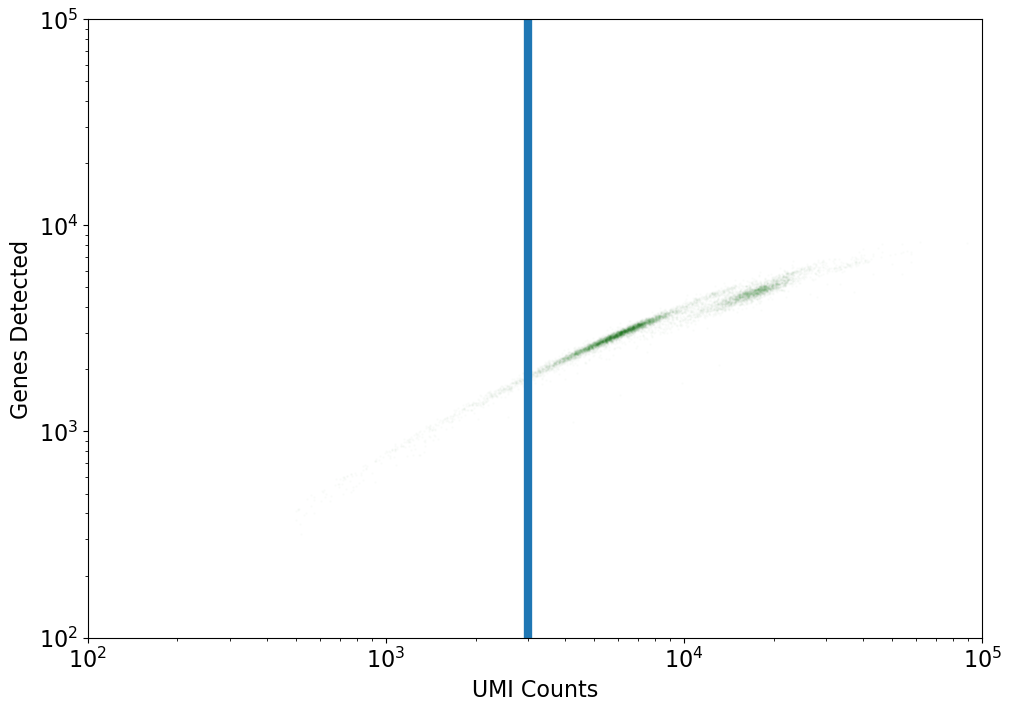

In [167]:
rna.X = rna.layers['ambiguous']+rna.layers['mature']+rna.layers['nascent']
mtx = rna.X

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", s=1, alpha=0.01)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((100,100000))
ax.set_ylim((100,100000))
ax.axvline(x=3000)

plt.show()

In [168]:
alldata = rna[np.asarray(mtx.sum(axis=1))>3000]
alldata

View of AnnData object with n_obs × n_vars = 8458 × 39583
    layers: 'ambiguous', 'mature', 'nascent'

In [185]:
tenx_common_bc_idx = np.array([np.where(np.array(tenx_barcode)==bc)[0][0] for bc in alldata.obs_names.tolist()])

protein = protein[tenx_common_bc_idx]
protein

View of AnnData object with n_obs × n_vars = 8458 × 140
    obs: 0
    var: 0, 1, 2

In [189]:
alldata.var['gene_id'] = alldata.var_names
alldata.var.index = [g.split('.')[0] for g in list(alldata.var_names)]
alldata.var

gene_id
ENSG00000228037  ENSG00000228037
ENSG00000142611  ENSG00000142611
ENSG00000284616  ENSG00000284616
ENSG00000157911  ENSG00000157911
ENSG00000260972  ENSG00000260972
...                          ...
ENSG00000275063  ENSG00000275063
ENSG00000277856  ENSG00000277856
ENSG00000271254  ENSG00000271254
ENSG00000268674  ENSG00000268674
ENSG00000277475  ENSG00000277475

[39583 rows x 1 columns]

## Scanpy clustering

```
T Cell Markers	CD3D	ENSG00000167286
T Cell Markers	CD3E	ENSG00000198851
T Cell Markers	CD4	ENSG00000010610
Cytotoxic/CD8 T Cells	GNLY	ENSG00000115523
Cytotoxic/CD8 T Cells	GZMB	ENSG00000100453
B Cell Markers	CD79A	ENSG00000105369
B Cell Markers	CD79B	ENSG00000007312
Monocyte Markers	CD14	ENSG00000170458
Proliferating Erythrocytes	HBG1	ENSG00000213934
Proliferating Erythrocytes	HBG2	ENSG00000196565

https://scanpy.readthedocs.io/en/stable/tutorials/basics/index.html

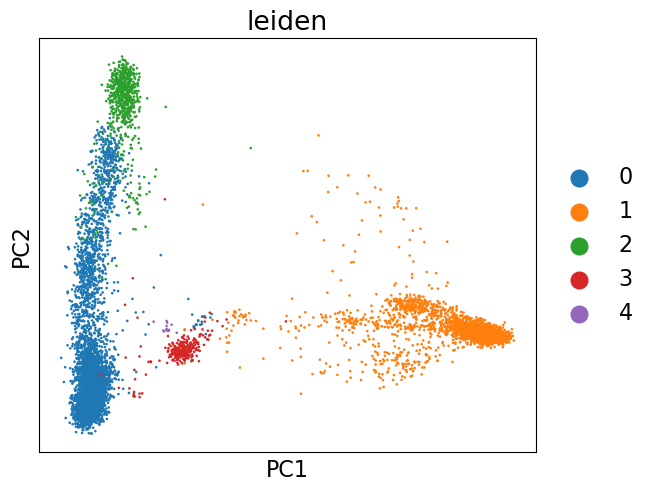

In [307]:
data = alldata.copy()

# Saving count data
data.layers["counts"] = data.X.copy()
sc.pp.normalize_total(data)
sc.pp.log1p(data)

sc.pp.highly_variable_genes(data, n_top_genes=2000)

# PCA and neighborhood graph
sc.tl.pca(data)
sc.pp.neighbors(data)
#sc.tl.umap(data)
#sc.tl.tsne(data)

# Clustering and t-SNE
sc.tl.leiden(data, resolution=0.02)
sc.pl.pca(data, color=["leiden"])

In [308]:
data.var['gene_id'] = data.var_names.copy()
data.var_names = [ g.split('.')[0] for g in data.var['gene_id'] ]
data.var

gene_id  highly_variable         means  dispersions  \
ENSG00000228037  ENSG00000228037            False  1.000000e-12          NaN   
ENSG00000142611  ENSG00000142611            False  6.994980e-04     0.077134   
ENSG00000284616  ENSG00000284616            False  1.000000e-12          NaN   
ENSG00000157911  ENSG00000157911            False  9.545713e-02     0.216307   
ENSG00000260972  ENSG00000260972            False  1.000000e-12          NaN   
...                          ...              ...           ...          ...   
ENSG00000275063  ENSG00000275063            False  1.000000e-12          NaN   
ENSG00000277856  ENSG00000277856            False  1.000000e-12          NaN   
ENSG00000271254  ENSG00000271254            False  1.000000e-12          NaN   
ENSG00000268674  ENSG00000268674            False  1.000000e-12          NaN   
ENSG00000277475  ENSG00000277475            False  1.000000e-12          NaN   

                 dispersions_norm  
ENSG00000228037               NaN  
ENSG00000142611         -0.162414  
ENSG00000284616               NaN  
ENSG00000157911          0.084388  
ENSG00000260972               NaN  
...                           ...  
ENSG00000275063               NaN  
ENSG00000277856               NaN  
ENSG00000271254               NaN  
ENSG00000268674               NaN  
ENSG00000277475               NaN  

[39583 rows x 5 columns]

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


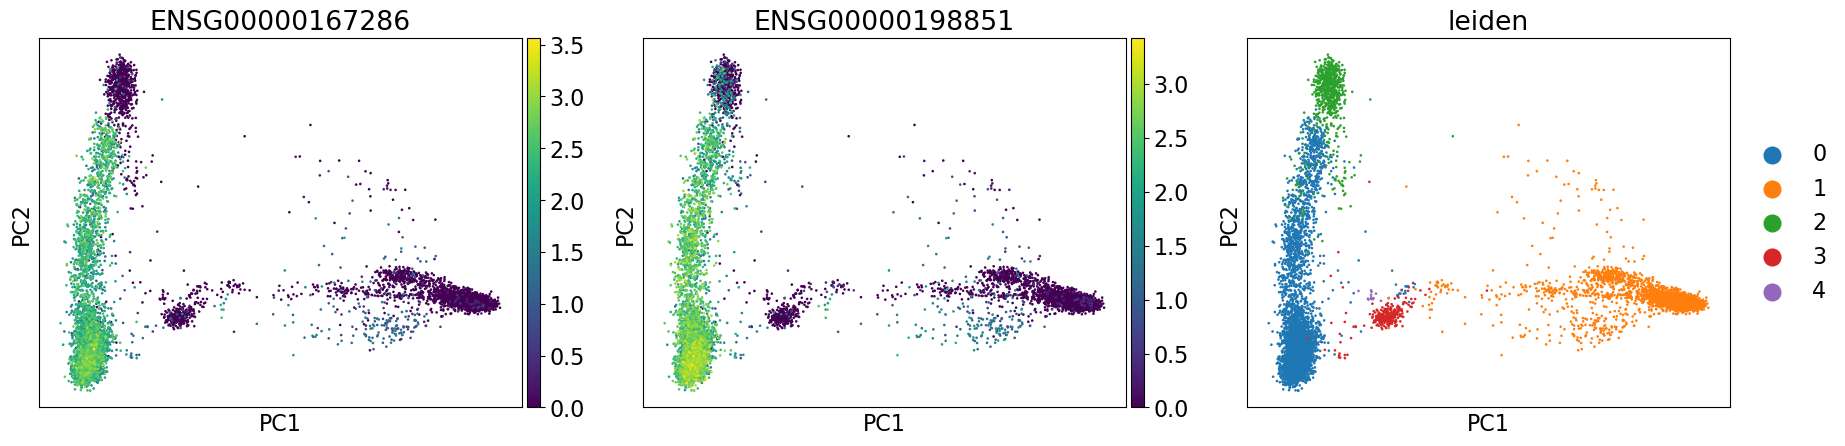

In [309]:
# T Cell: CD3
sc.pl.pca(data,color=['ENSG00000167286','ENSG00000198851',"leiden"])

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


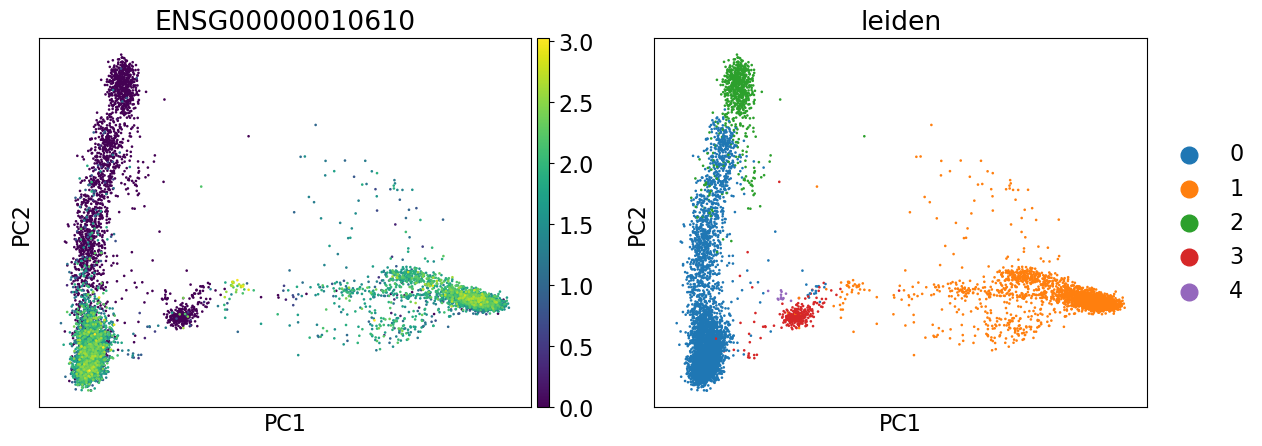

In [310]:
# Helper T Cell: CD4
sc.pl.pca(data,color=['ENSG00000010610',"leiden"])

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


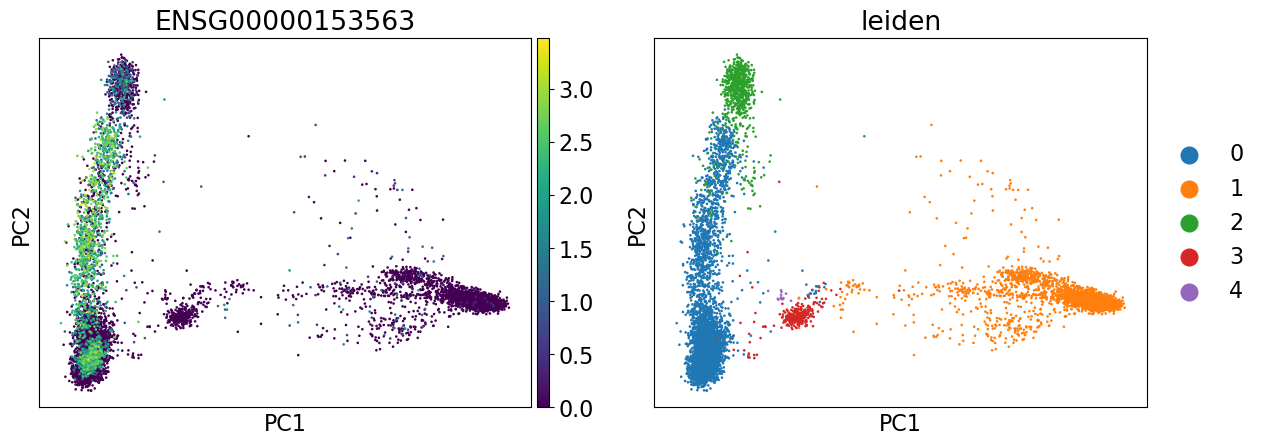

In [311]:
# Cytotoxic T Cell: CD8
sc.pl.pca(data,color=['ENSG00000153563',"leiden"])

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


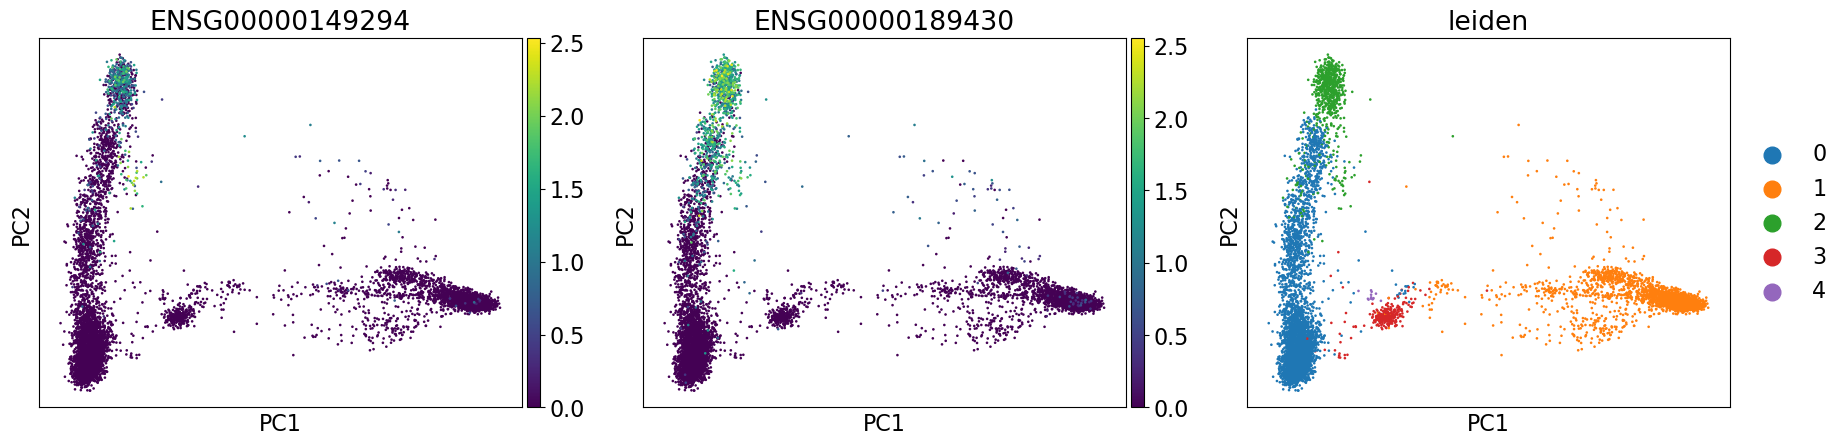

In [312]:
# NK cells: cd56
sc.pl.pca(data,color=['ENSG00000149294','ENSG00000189430',"leiden"])

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


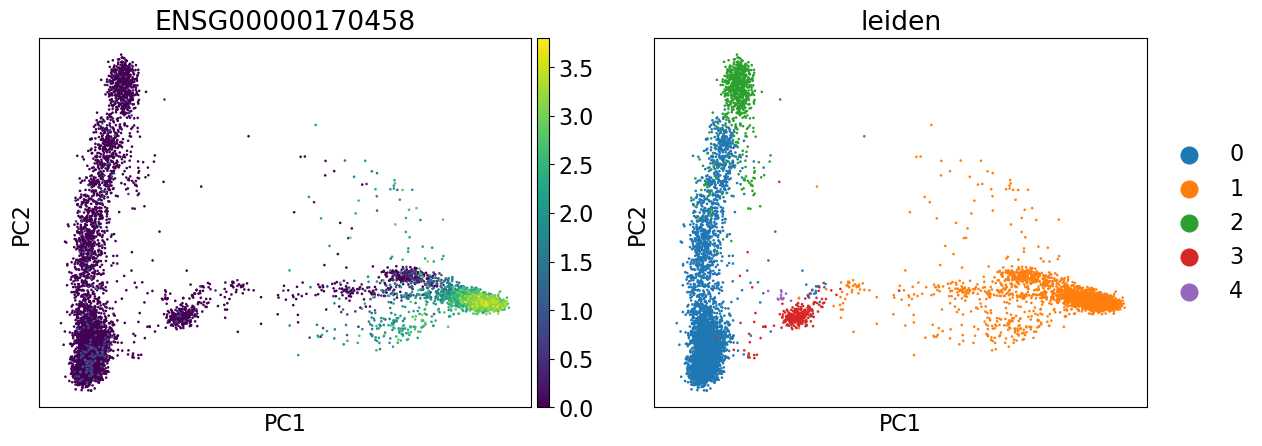

In [313]:
# Monocyte cells: cd14
sc.pl.pca(data,color=['ENSG00000170458',"leiden"])

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


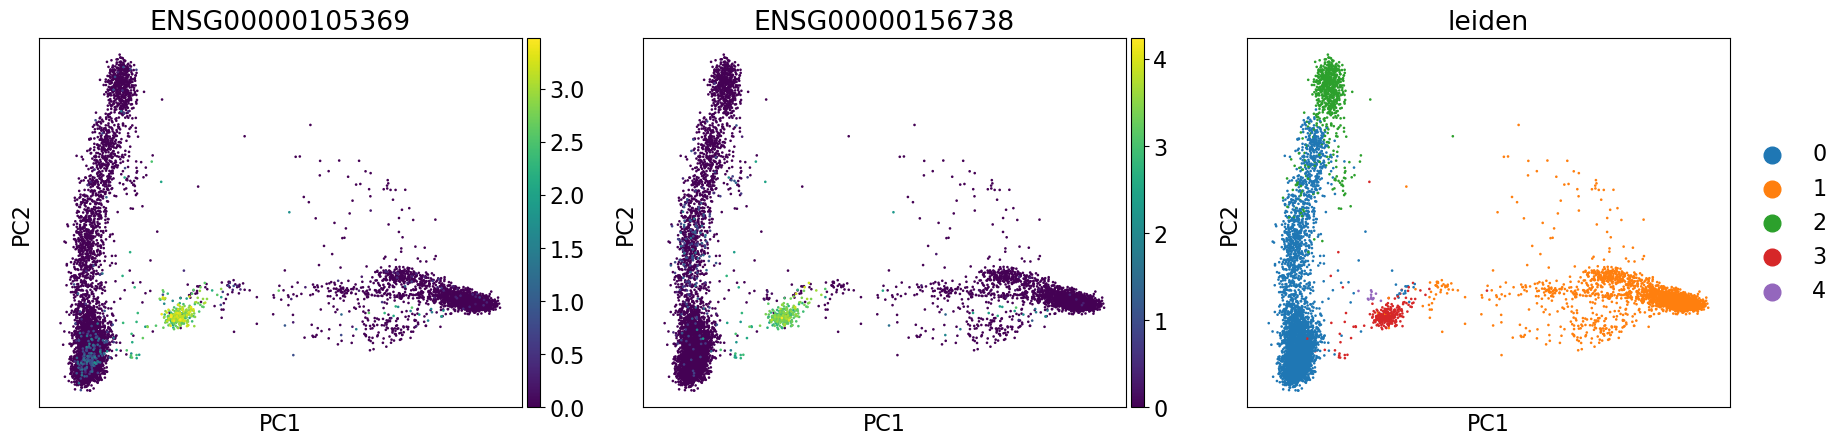

In [314]:
# B cells
sc.pl.pca(data,color=['ENSG00000105369','ENSG00000156738',"leiden"])

In [315]:
# Define the mapping from Leiden clusters to cell types
leiden_to_celltype = {
    "0": "T cells",
    "1": "Monocytes",
    "2": "NK cells",
    "3": "B cells",
    "4": "B cells"
}

# Map the Leiden cluster values to cell types
adata.obs["celltype"] = data.obs["leiden"].map(leiden_to_celltype)
adata.obs

GMM_cluster   celltype
barcode                                
AAACAAGCACCATACT           0    T cells
AAACAAGCACGTAATG           0    T cells
AAACAAGCATGCAATG           0    T cells
AAACAAGCATTTGGGA           0    T cells
AAACCAATCAAGTTTC           2  Monocytes
...                      ...        ...
TTTGTGAGTACAAACG           1  Monocytes
TTTGTGAGTCGAGGCA           0    T cells
TTTGTGAGTGCGGAAT           0    T cells
TTTGTGAGTGGCTCAC           0    T cells
TTTGTGAGTTCAAGGA           2  Monocytes

[8458 rows x 2 columns]

# Normalized covariance

0.0002562269713310087 0.05406136999023522 0.20383241031427257


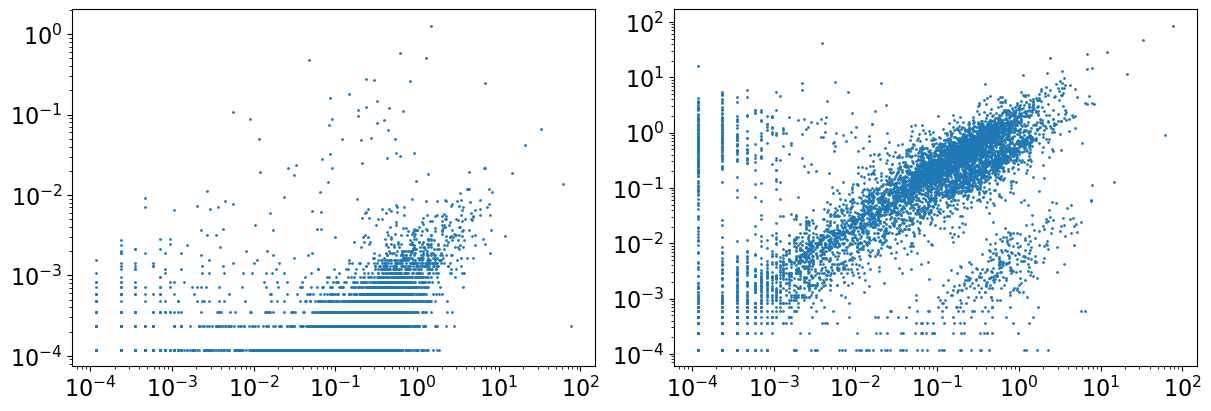

In [194]:
adata = alldata.copy()
adata.layers['spliced'] = adata.layers['mature'] + adata.layers['ambiguous']
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['nascent'].toarray().mean(0),s=1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['ambiguous'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['nascent'].toarray().mean(),adata.layers['mature'].toarray().mean(),adata.layers['ambiguous'].toarray().mean())

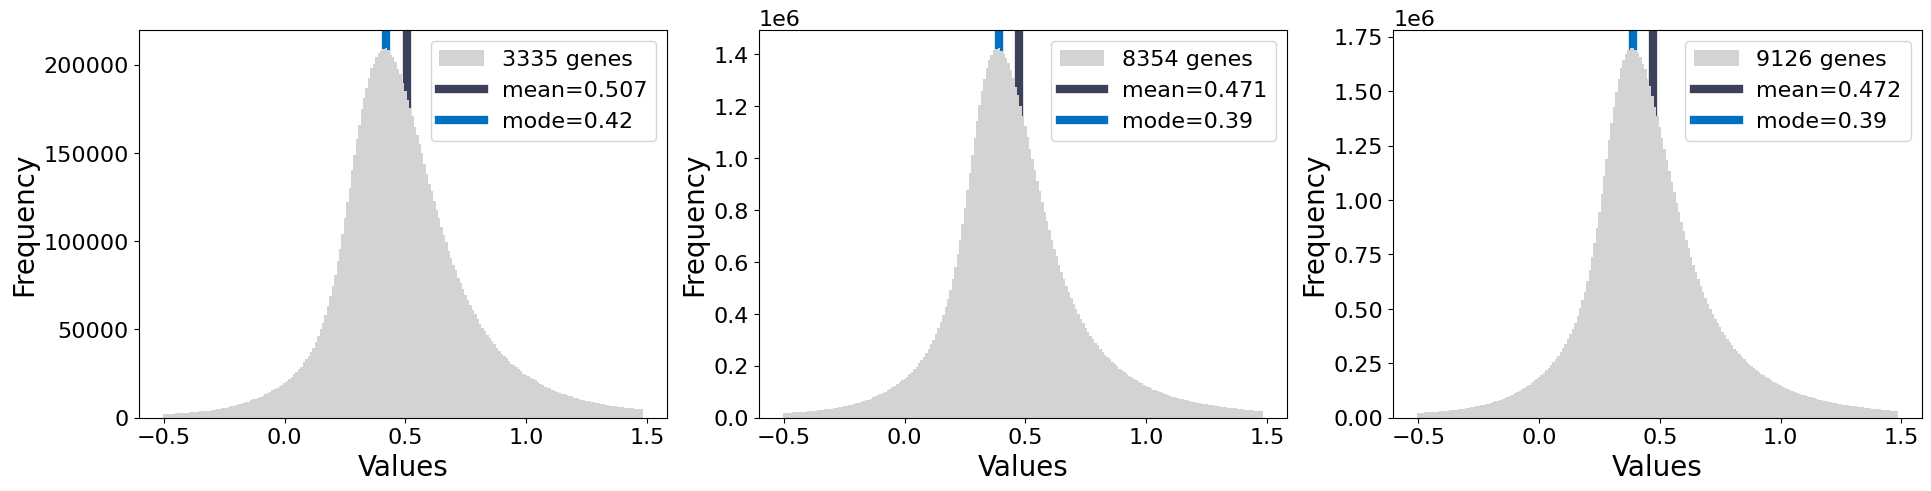

In [21]:
fig,axs = plt.subplots(1,3,figsize=(19.2,4.8))

s_mm = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1)
s_nn = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[1],min_mean=0.1)
s_mm = estimate_s(N1=adata.layers["spliced"].toarray(),ax=axs[2],min_mean=0.1)

for i in range(3):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

Text(0.5, 0, 'Values')

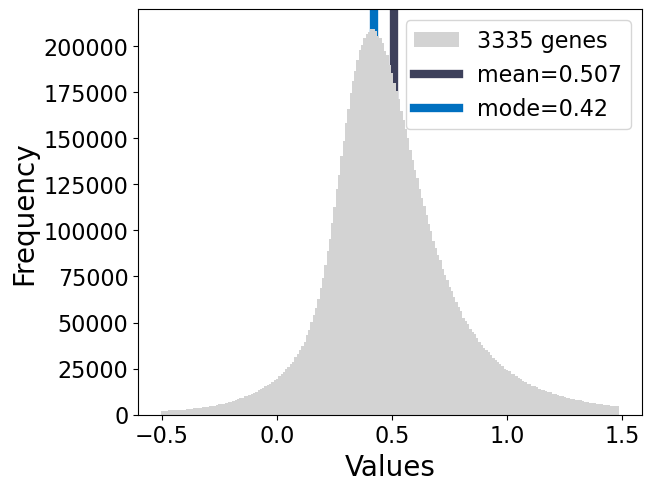

In [202]:
fig,axs = plt.subplots(1,1)
_ = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs,min_mean=0.1)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Values',fontsize=20)

In [201]:
X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(overdispersion,[X_],B=1000,n_cores=50)

Text(0.5, 0, 'Values')

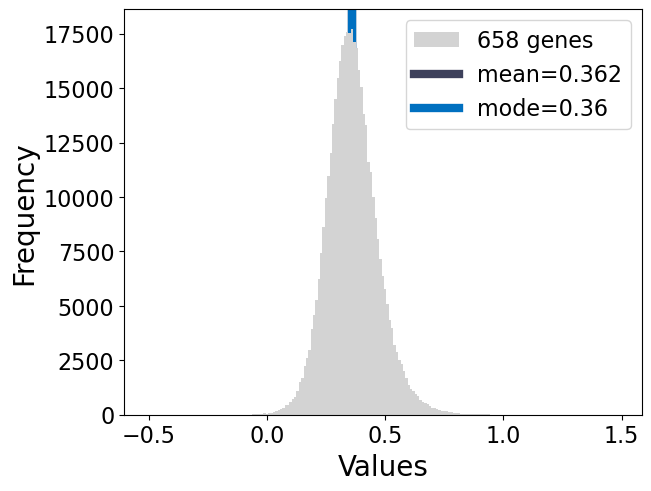

In [385]:
ss = 0.36

S_Pgene_mask = (ss < upper_bound) & (ss > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

fig,axs = plt.subplots(1,1)

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers["mature"].toarray()[:,idx]
s = estimate_s(X_S,ax=axs,min_mean=0.1)

axs.set_ylabel('Frequency',fontsize=20)
axs.set_xlabel('Values',fontsize=20)

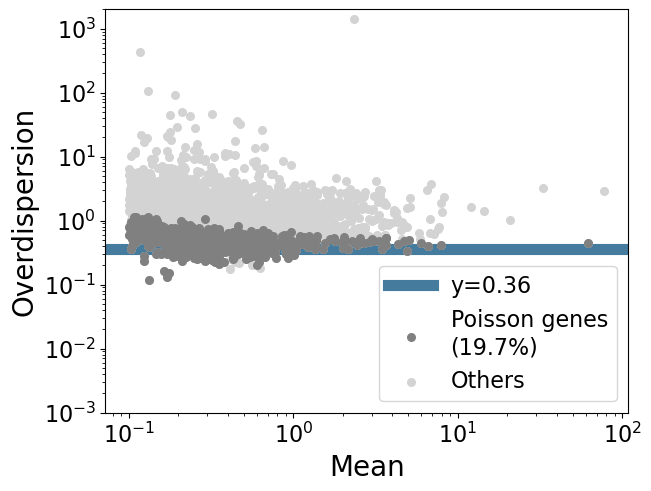

In [387]:
s = ss
X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = S_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='Poisson genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-3,2e3])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Overdispersion',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

In [388]:
# Save to text file (each string will be on a new line)
np.savetxt("results/pbmc_Pgenes.txt", np.array(S_Pgene), fmt='%s')

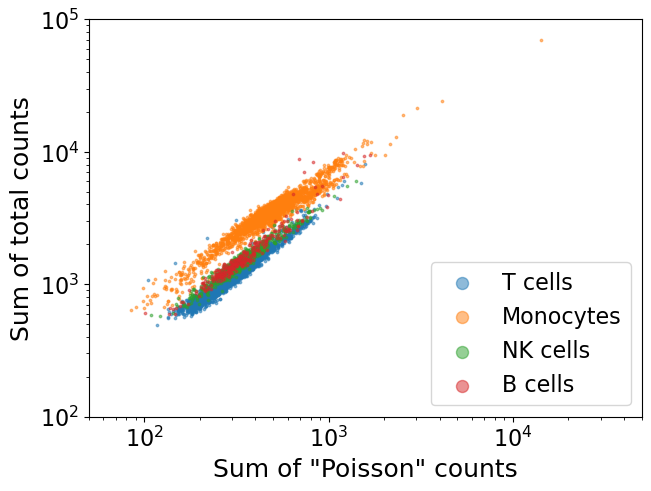

In [434]:
# Preprocessing
X_ = adata.layers["mature"].toarray().copy()
nonzero_idx = X_.mean(0) > 0.1
X_ = X_[:, nonzero_idx]
cellsize_S = X_[:, S_Pgene_mask].sum(1)
cellsize_X = adata.layers["mature"].toarray().copy().sum(1)

# Extract class labels
class_labels = adata.obs["celltype"]

# Map unique labels to distinct colors
unique_labels = ['T cells','Monocytes','NK cells','B cells']
color_map = dict(zip(unique_labels, plt.cm.tab10.colors[:len(unique_labels)]))  # Choose a colormap

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8))
for label in unique_labels:
    idx = class_labels == label
    ax.scatter(
        cellsize_S[idx], 
        cellsize_X[idx], 
        s=3, 
        alpha=0.5,
        color=color_map[label], 
        label=label
    )
 
ax.set_ylim((1e2,1e5))
ax.set_xlim((5e1,5e4))

# Set log-log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Add legend and labels
plt.legend(loc="lower right", markerscale=5, fontsize=16)
plt.xlabel('Sum of "Poisson" counts', fontsize=18)
plt.ylabel('Sum of total counts', fontsize=18)
plt.show()

In [425]:
x = cellsize_S/cellsize_S.mean()
y = cellsize_X/cellsize_X.mean()
print('r='+str(np.around(np.corrcoef(x,y)[0,1],2)))

r=0.91


In [390]:
data = adata.copy()

sc.pp.normalize_total(data)
sc.pp.log1p(data)

sc.pp.highly_variable_genes(data, n_top_genes=10000)

In [391]:
hv_genes = data.var_names[data.var['highly_variable'] == True]
hv_genes

Index(['ENSG00000142611', 'ENSG00000157911', 'ENSG00000142655',
       'ENSG00000149527', 'ENSG00000171621', 'ENSG00000142583',
       'ENSG00000173614', 'ENSG00000204624', 'ENSG00000142606',
       'ENSG00000157881',
       ...
       'ENSG00000169083', 'ENSG00000114374', 'ENSG00000198692',
       'ENSG00000012817', 'ENSG00000129824', 'ENSG00000067646',
       'ENSG00000154620', 'ENSG00000092377', 'ENSG00000165246',
       'ENSG00000099715'],
      dtype='object', length=10000)

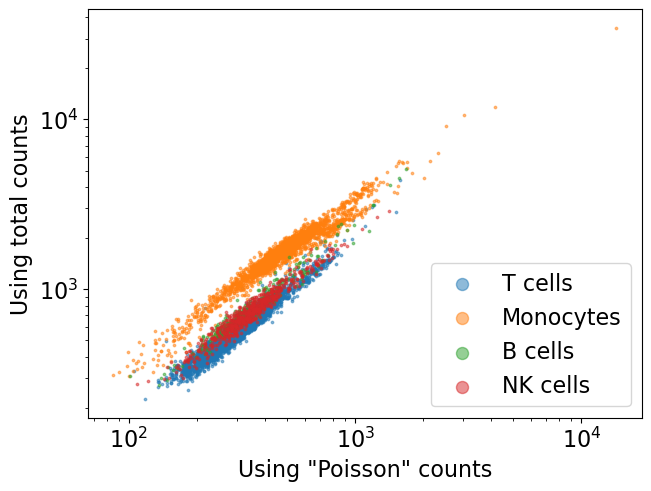

r=0.92


In [430]:
cellsize_X = adata.layers["mature"].toarray()[:,~adata.var_names.isin(hv_genes)].sum(1)

# Map unique labels to distinct colors
unique_labels = class_labels.unique()
color_map = dict(zip(unique_labels, plt.cm.tab10.colors[:len(unique_labels)]))  # Choose a colormap

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8))
for label in unique_labels:
    idx = class_labels == label
    ax.scatter(
        cellsize_S[idx], 
        cellsize_X[idx], 
        s=3, 
        alpha=0.5,
        color=color_map[label], 
        label=label
    )
 
#ax.set_ylim((1e2,1e4))
#ax.set_xlim((1e2,1e4))

# Set log-log scale
ax.set_xscale('log')
ax.set_yscale('log')

# Add legend and labels
plt.legend(loc="lower right", markerscale=5, fontsize=16)
plt.xlabel('Using "Poisson" counts', fontsize=16)
plt.ylabel('Using total counts', fontsize=16)
plt.show()

x = cellsize_S/cellsize_S.mean()
y = cellsize_X/cellsize_X.mean()
print('r='+str(np.around(np.corrcoef(x,y)[0,1],2)))

# Analysis

## DE

In [393]:
from scipy.stats import mannwhitneyu

In [394]:
X = adata.layers["mature"].toarray()/cellsize_S[:,None]*np.median(cellsize_S)

x = X[adata.obs["celltype"]=='NK cells']
y = X[adata.obs["celltype"]=='Monocytes']

In [395]:
U1, p1 = mannwhitneyu(x,y)

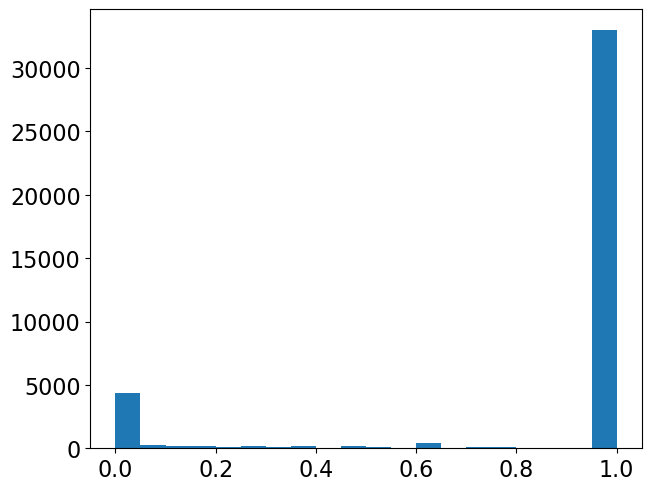

In [396]:
plt.hist(p1,bins=20);

In [397]:
X = adata.layers["mature"].toarray()/cellsize_X[:,None]*np.median(cellsize_X)

x = X[adata.obs["celltype"]=='NK cells']
y = X[adata.obs["celltype"]=='Monocytes']

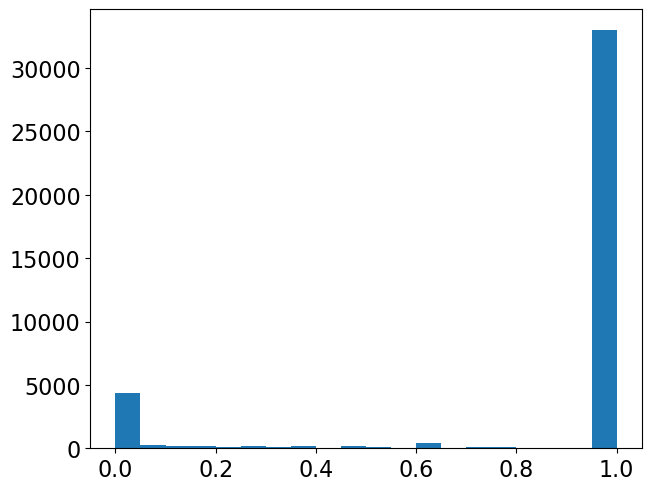

In [398]:
U2, p2 = mannwhitneyu(x,y)
plt.hist(p1,bins=20);

/tmp/ipykernel_2971045/4207257059.py:4: RuntimeWarning: divide by zero encountered in log10
  log_p1 = np.log10(p1)
/tmp/ipykernel_2971045/4207257059.py:5: RuntimeWarning: divide by zero encountered in log10
  log_p2 = np.log10(p2)


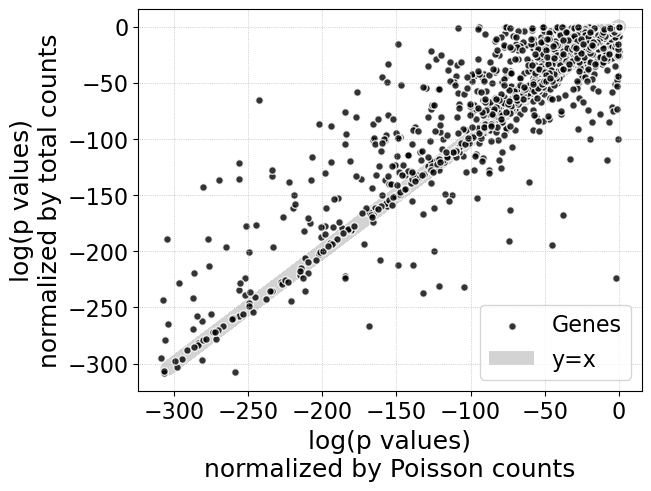

In [452]:
plt.figure()

# Take log10 of the data
log_p1 = np.log10(p1)
log_p2 = np.log10(p2)


# Scatter plot
plt.scatter(log_p1, log_p2, s=30, color='k', edgecolor='white', alpha=0.8, label='Genes')

# Reference line y = x in log-log space
plt.plot(log_p1, log_p1, color='lightgray', linestyle='--', linewidth=10, label='y=x', zorder=0)

# Labels, ticks, and title
plt.xlabel("log(p values)\nnormalized by Poisson counts", fontsize=18)
plt.ylabel("log(p values)\nnormalized by total counts", fontsize=18)
plt.grid(True, linestyle=':', linewidth=0.5)
plt.legend(loc='lower right')

plt.show()

/tmp/ipykernel_2971045/2620697226.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


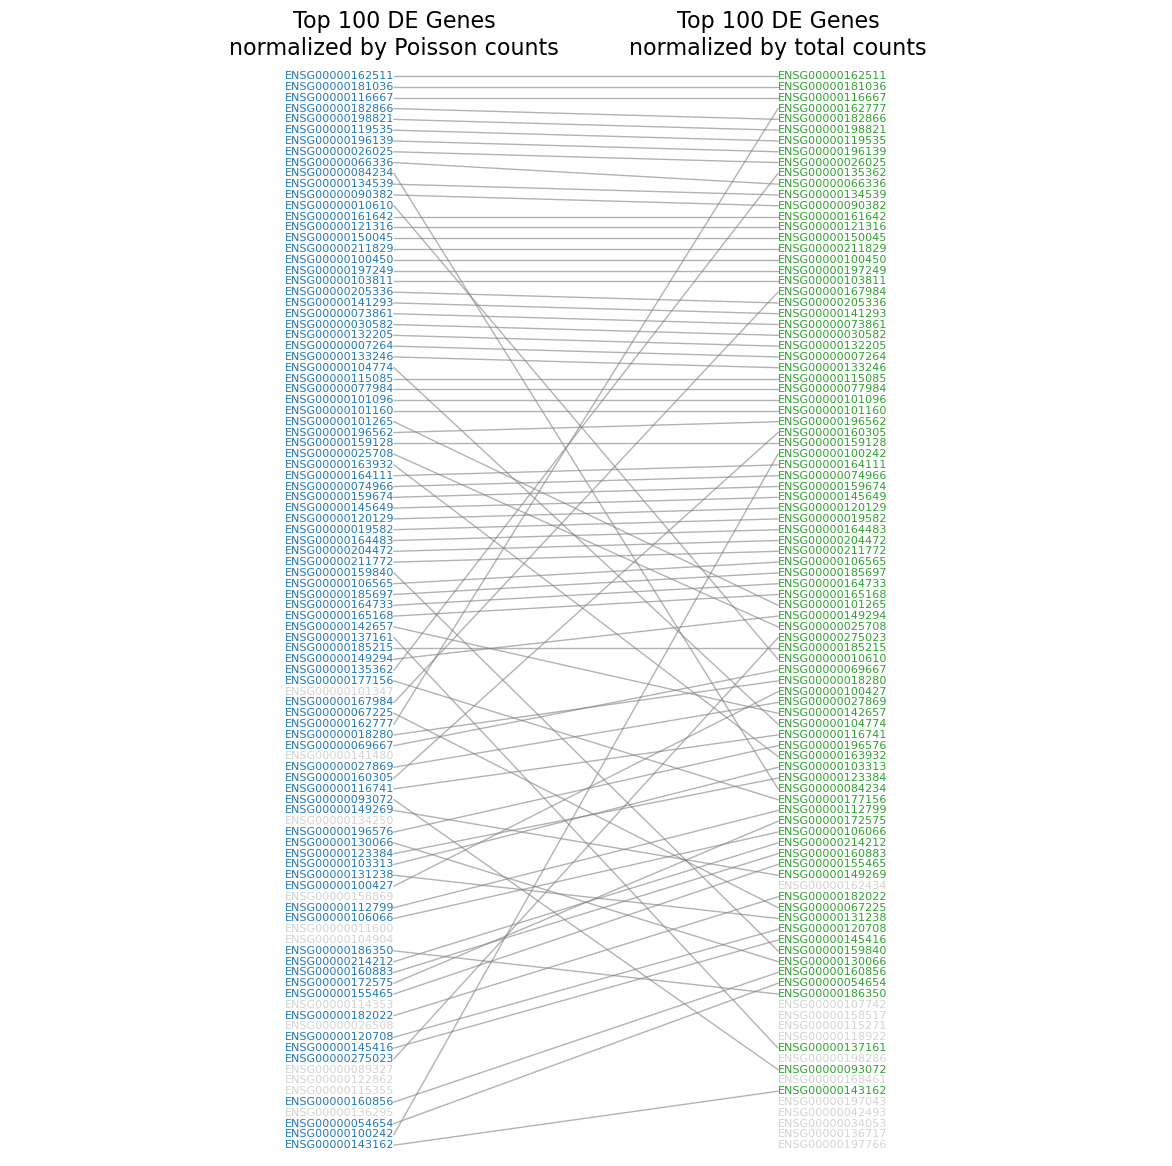

In [465]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Step 1: Convert to pandas Series
genes = adata.var_names
p1_series = pd.Series(p1, index=genes)
p2_series = pd.Series(p2, index=genes)

# Top 100
top100_p1 = p1_series.nsmallest(100)
top100_p2 = p2_series.nsmallest(100)

genes_p1 = list(top100_p1.index)
genes_p2 = list(top100_p2.index)
common_genes = set(genes_p1) & set(genes_p2)

# Create position maps
pos_p1 = {gene: 100 - i for i, gene in enumerate(genes_p1)}
pos_p2 = {gene: 100 - i for i, gene in enumerate(genes_p2)}

# Start plotting
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_xlim(-1, 2)
ax.set_ylim(0, 105)
ax.axis('off')

# Draw left (p1) column
for i, gene in enumerate(genes_p1):
    y = pos_p1[gene]
    color = 'tab:blue' if gene in common_genes else 'lightgray'
    ax.text(0, y, gene, va='center', ha='right', fontsize=8, color=color)

# Draw right (p2) column
for i, gene in enumerate(genes_p2):
    y = pos_p2[gene]
    color = 'tab:green' if gene in common_genes else 'lightgray'
    ax.text(1, y, gene, va='center', ha='left', fontsize=8, color=color)

# Draw connections
for gene in common_genes:
    y1 = pos_p1[gene]
    y2 = pos_p2[gene]
    ax.plot([0, 1], [y1, y2], color='gray', alpha=0.6, linewidth=1)

# Titles
ax.text(0, 102, 'Top 100 DE Genes\nnormalized by Poisson counts', fontsize=16, ha='center')
ax.text(1, 102, 'Top 100 DE Genes\nnormalized by total counts', fontsize=16, ha='center')

plt.tight_layout()
plt.show()

## PCA + GMM

In [171]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import pandas as pd

In [242]:
X = adata.layers["mature"].toarray()

# Apply PCA
pca = PCA(n_components=50) # if n_components is not set all components are kept
y_pca = pca.fit_transform(X)

'''
fig, ax = plt.subplots(figsize=(6,4.8))
for label in unique_labels:
    idx = class_labels == label
    ax.scatter(
        y_pca[idx,0], 
        y_pca[idx,1], 
        s=10, 
        alpha=0.5,
        color=color_map[label], 
        label=label
    )
ax.legend(loc=(1.1,0.2), markerscale=5, title="Cell types")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()
'''

gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=0)
gmm.fit(y_pca)

# Predict cluster assignments
labels = gmm.predict(y_pca)

# Add GMM cluster labels to adata.obs
adata.obs['GMM_cluster'] = labels.astype(str)  # convert to string for better plotting

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


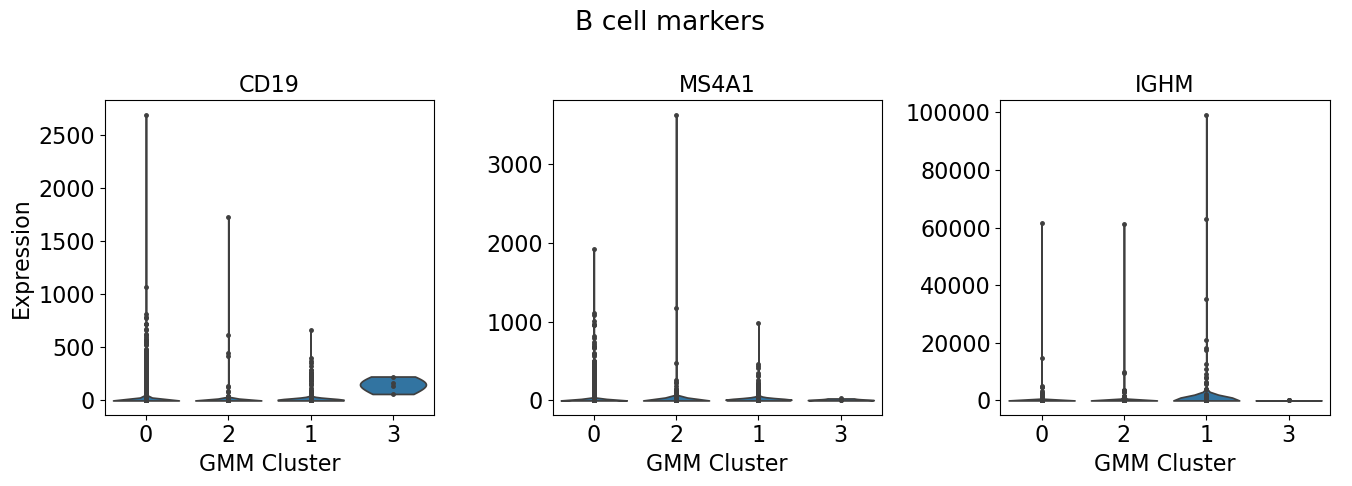

In [244]:
# List of gene IDs to plot
genes = ['CD19', 'MS4A1', 'IGHM']

# Create long-format dataframe for seaborn
plot_data = pd.DataFrame({
    'GMM_cluster': adata.obs['GMM_cluster']
})

# Add gene expression per cell
for gene in genes:
    plot_data[gene] = protein[:, gene].X.toarray().flatten() if hasattr(protein[:, gene].X, 'toarray') else protein[:, gene].X.flatten()

# Melt for long format
long_df = plot_data.melt(id_vars='GMM_cluster', value_vars=genes, var_name='Gene', value_name='Expression')

# Use seaborn catplot to facet by gene
g = sns.catplot(
    data=long_df,
    x='GMM_cluster',
    y='Expression',
    col='Gene',
    kind='violin',
    inner='point',
    cut=0,
    density_norm='width',
    height=5,
    aspect=0.9,
    sharey=False  # optional: allows each gene to have its own y-axis scale
)

g.set_titles(col_template='{col_name}')
g.set_axis_labels('GMM Cluster', 'Expression')

for ax in g.axes.flat:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
plt.suptitle('B cell markers')
plt.tight_layout()
plt.show()

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


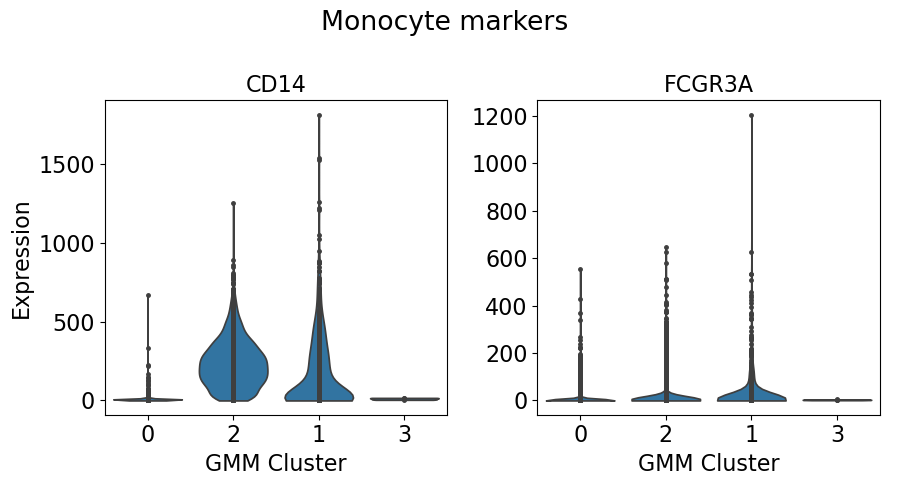

In [245]:
# List of gene IDs to plot
genes = ['CD14', 'FCGR3A']

# Create long-format dataframe for seaborn
plot_data = pd.DataFrame({
    'GMM_cluster': adata.obs['GMM_cluster']
})

# Add gene expression per cell
for gene in genes:
    plot_data[gene] = protein[:, gene].X.toarray().flatten() if hasattr(protein[:, gene].X, 'toarray') else protein[:, gene].X.flatten()

# Melt for long format
long_df = plot_data.melt(id_vars='GMM_cluster', value_vars=genes, var_name='Gene', value_name='Expression')

# Use seaborn catplot to facet by gene
g = sns.catplot(
    data=long_df,
    x='GMM_cluster',
    y='Expression',
    col='Gene',
    kind='violin',
    inner='point',
    cut=0,
    density_norm='width',
    height=5,
    aspect=0.9,
    sharey=False  # optional: allows each gene to have its own y-axis scale
)

g.set_titles(col_template='{col_name}')
g.set_axis_labels('GMM Cluster', 'Expression')

for ax in g.axes.flat:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
plt.suptitle('Monocyte markers')
plt.tight_layout()
plt.show()

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


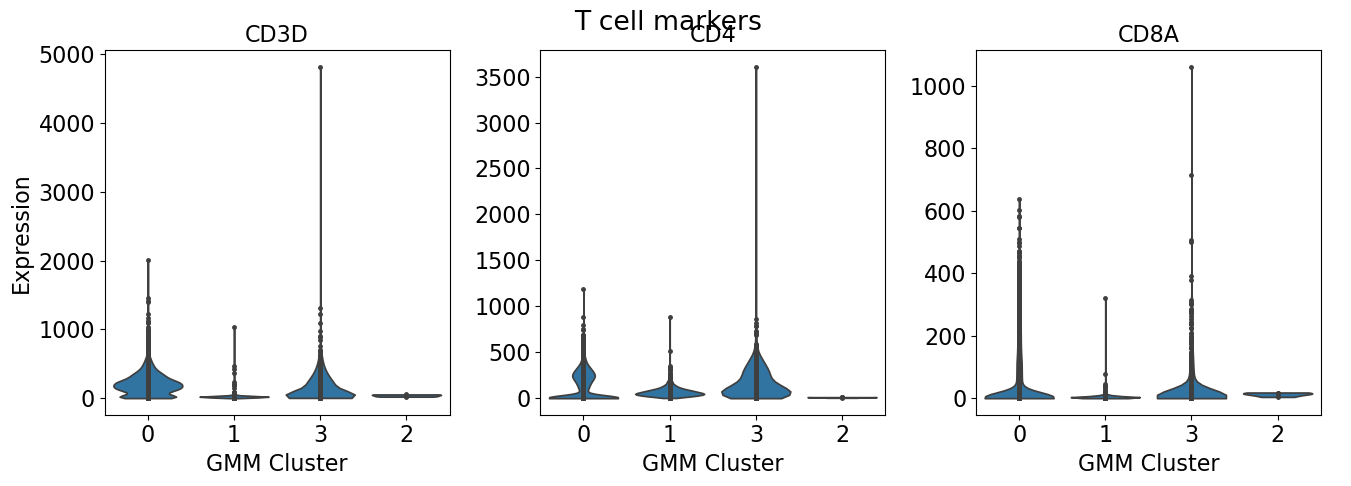

In [224]:
# List of gene IDs to plot
genes = ['CD3D','CD4', 'CD8A']

# Create long-format dataframe for seaborn
plot_data = pd.DataFrame({
    'GMM_cluster': adata.obs['GMM_cluster']
})

# Add gene expression per cell
for gene in genes:
    plot_data[gene] = protein[:, gene].X.toarray().flatten() if hasattr(protein[:, gene].X, 'toarray') else protein[:, gene].X.flatten()

# Melt for long format
long_df = plot_data.melt(id_vars='GMM_cluster', value_vars=genes, var_name='Gene', value_name='Expression')

# Use seaborn catplot to facet by gene
g = sns.catplot(
    data=long_df,
    x='GMM_cluster',
    y='Expression',
    col='Gene',
    kind='violin',
    inner='point',
    cut=0,
    density_norm='width',
    height=5,
    aspect=0.9,
    sharey=False  # optional: allows each gene to have its own y-axis scale
)

g.set_titles(col_template='{col_name}')
g.set_axis_labels('GMM Cluster', 'Expression')

for ax in g.axes.flat:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
plt.suptitle('T cell markers')

plt.show()

### scanpy

In [420]:
X = np.log1p(adata.layers["mature"].toarray()/adata.layers["mature"].toarray().sum(1)[:,None]*np.median(adata.layers["mature"].toarray().sum(1)))

# Apply PCA
pca = PCA(n_components=50) # if n_components is not set all components are kept
y_pca = pca.fit_transform(X)

gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=0)
gmm.fit(y_pca)

# Predict cluster assignments
labels = gmm.predict(y_pca)

# Add GMM cluster labels to adata.obs
adata.obs['GMM_cluster'] = labels.astype(str)  # convert to string for better plotting

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


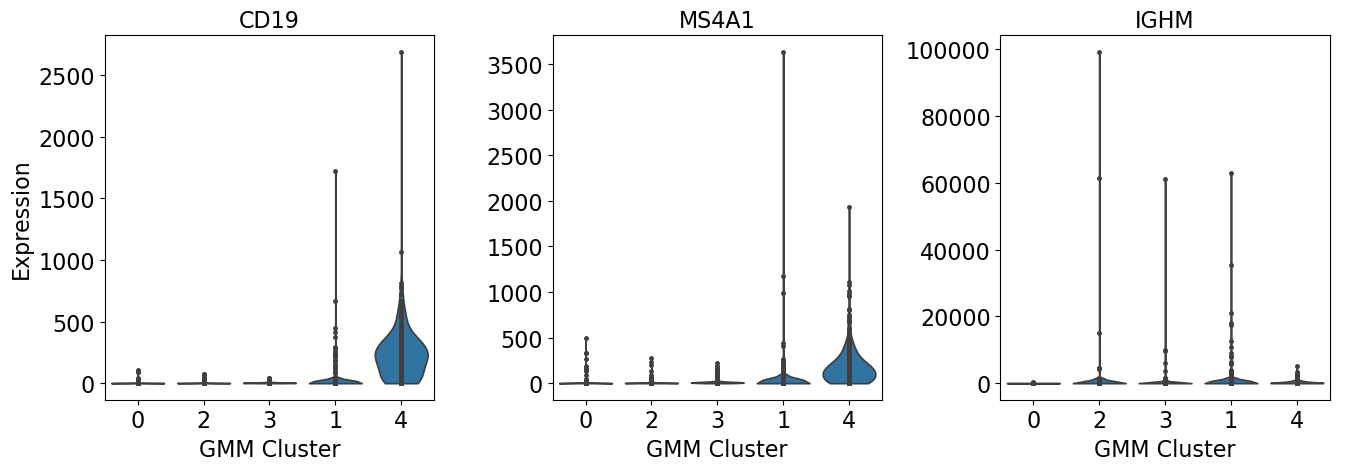

In [421]:
# List of gene IDs to plot
genes = ['CD19', 'MS4A1', 'IGHM']

# Create long-format dataframe for seaborn
plot_data = pd.DataFrame({
    'GMM_cluster': adata.obs['GMM_cluster']
})

# Add gene expression per cell
for gene in genes:
    plot_data[gene] = protein[:, gene].X.toarray().flatten() if hasattr(protein[:, gene].X, 'toarray') else protein[:, gene].X.flatten()

# Melt for long format
long_df = plot_data.melt(id_vars='GMM_cluster', value_vars=genes, var_name='Gene', value_name='Expression')

# Use seaborn catplot to facet by gene
g = sns.catplot(
    data=long_df,
    x='GMM_cluster',
    y='Expression',
    col='Gene',
    kind='violin',
    inner='point',
    cut=0,
    density_norm='width',
    height=5,
    aspect=0.9,
    sharey=False  # optional: allows each gene to have its own y-axis scale
)

g.set_titles(col_template='{col_name}')
g.set_axis_labels('GMM Cluster', 'Expression')

for ax in g.axes.flat:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
plt.tight_layout()
plt.show()

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


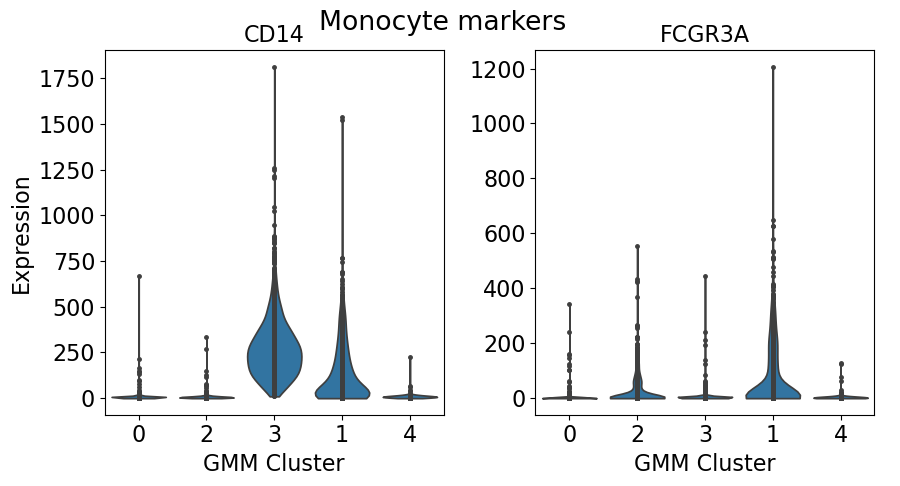

In [422]:
# List of gene IDs to plot
genes = ['CD14', 'FCGR3A']

# Create long-format dataframe for seaborn
plot_data = pd.DataFrame({
    'GMM_cluster': adata.obs['GMM_cluster']
})

# Add gene expression per cell
for gene in genes:
    plot_data[gene] = protein[:, gene].X.toarray().flatten() if hasattr(protein[:, gene].X, 'toarray') else protein[:, gene].X.flatten()

# Melt for long format
long_df = plot_data.melt(id_vars='GMM_cluster', value_vars=genes, var_name='Gene', value_name='Expression')

# Use seaborn catplot to facet by gene
g = sns.catplot(
    data=long_df,
    x='GMM_cluster',
    y='Expression',
    col='Gene',
    kind='violin',
    inner='point',
    cut=0,
    density_norm='width',
    height=5,
    aspect=0.9,
    sharey=False  # optional: allows each gene to have its own y-axis scale
)

g.set_titles(col_template='{col_name}')
g.set_axis_labels('GMM Cluster', 'Expression')

for ax in g.axes.flat:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
plt.suptitle('Monocyte markers')
plt.show()

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


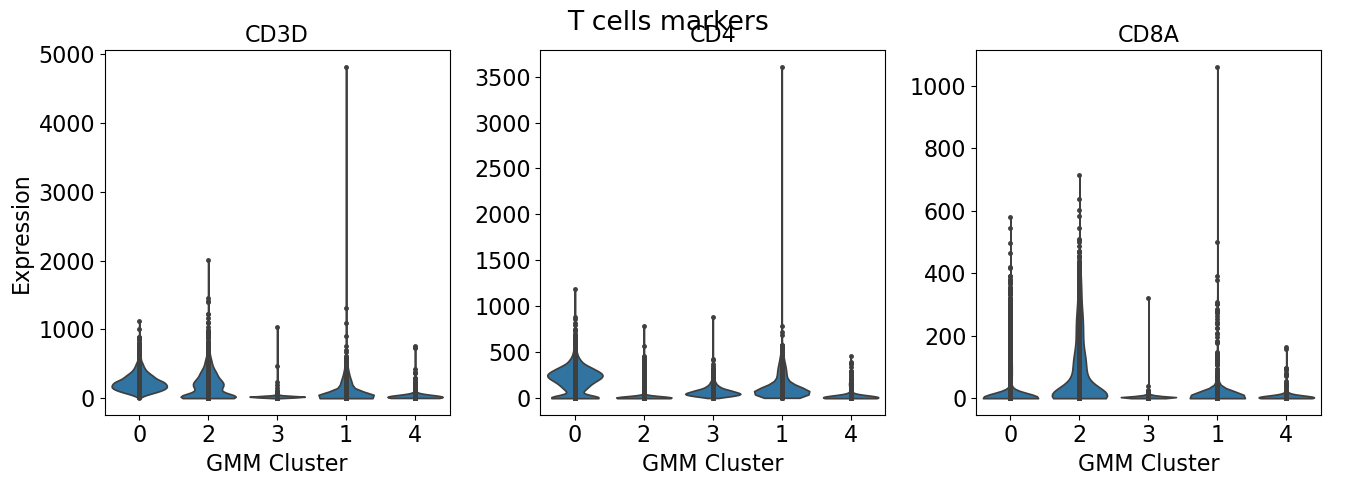

In [423]:
# List of gene IDs to plot
genes = ['CD3D','CD4', 'CD8A']

# Create long-format dataframe for seaborn
plot_data = pd.DataFrame({
    'GMM_cluster': adata.obs['GMM_cluster']
})

# Add gene expression per cell
for gene in genes:
    plot_data[gene] = protein[:, gene].X.toarray().flatten() if hasattr(protein[:, gene].X, 'toarray') else protein[:, gene].X.flatten()

# Melt for long format
long_df = plot_data.melt(id_vars='GMM_cluster', value_vars=genes, var_name='Gene', value_name='Expression')

# Use seaborn catplot to facet by gene
g = sns.catplot(
    data=long_df,
    x='GMM_cluster',
    y='Expression',
    col='Gene',
    kind='violin',
    inner='point',
    cut=0,
    density_norm='width',
    height=5,
    aspect=0.9,
    sharey=False  # optional: allows each gene to have its own y-axis scale
)

g.set_titles(col_template='{col_name}')
g.set_axis_labels('GMM Cluster', 'Expression')

for ax in g.axes.flat:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
plt.suptitle('T cells markers')
plt.show()

### normalization

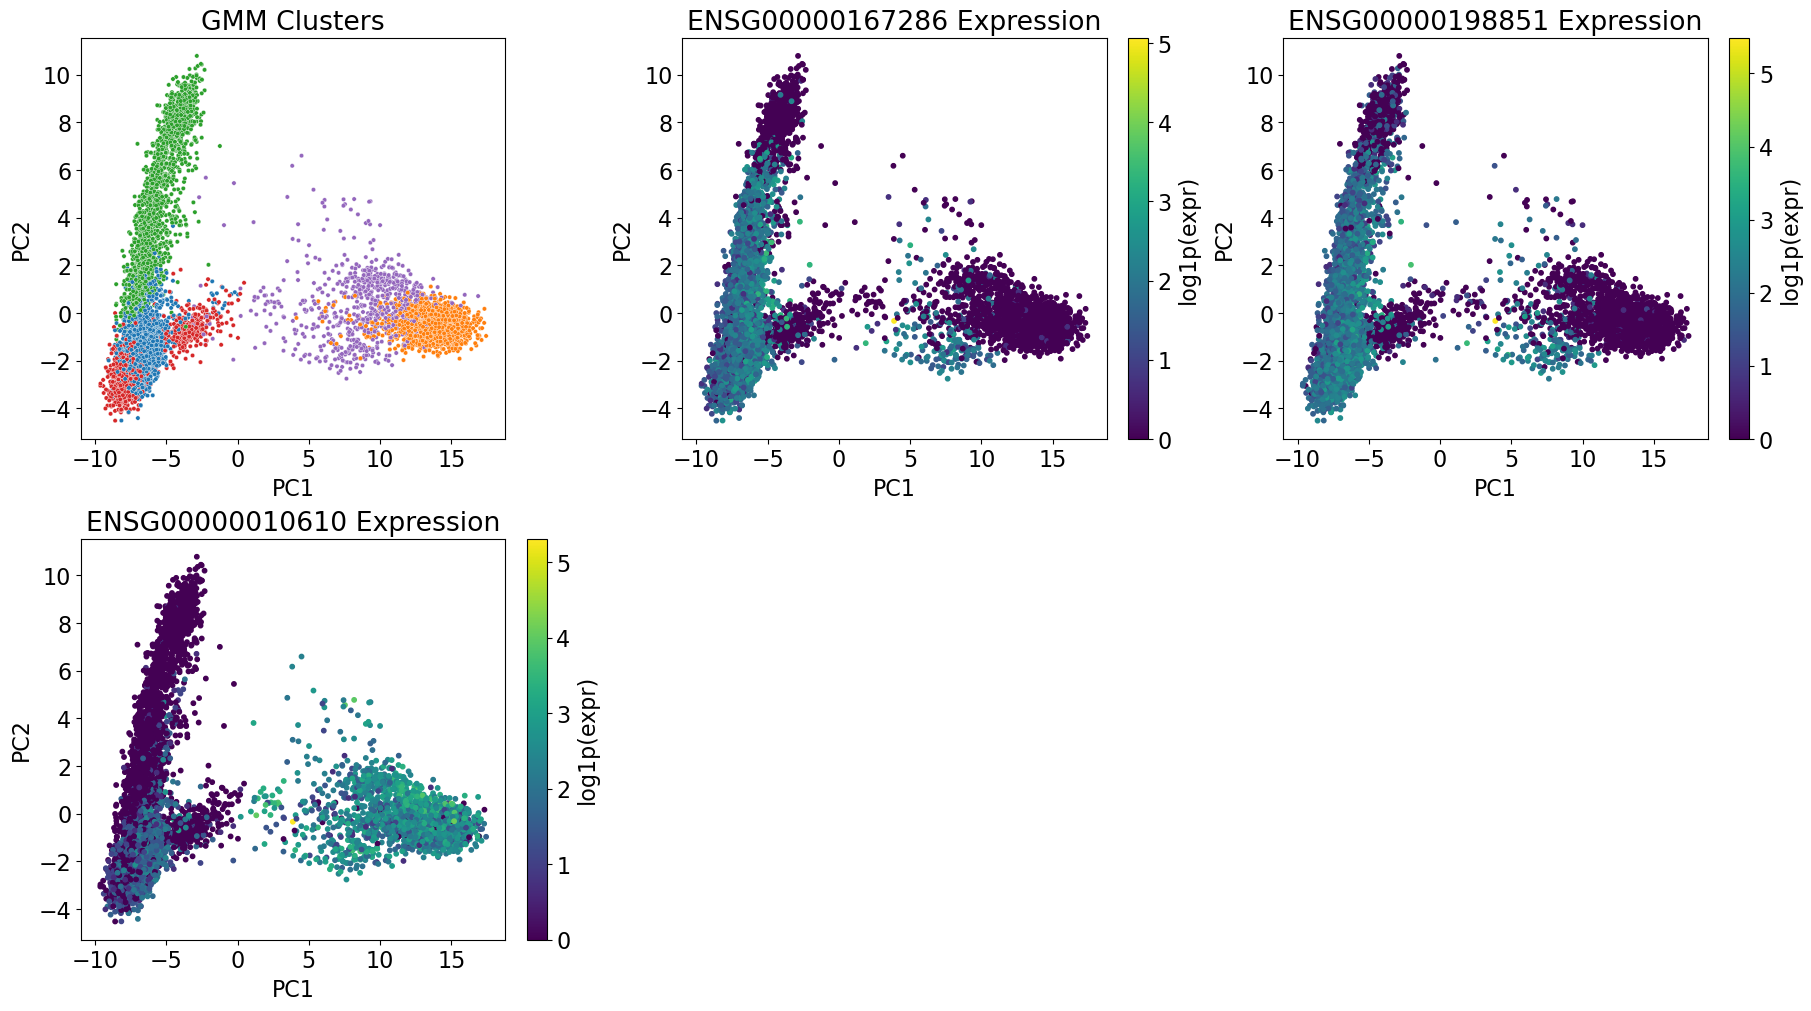

In [416]:
X = np.log1p(adata.layers["mature"].toarray()/cellsize_S[:,None]*np.median(cellsize_S))

# Apply PCA
pca = PCA(n_components=50) # if n_components is not set all components are kept
y_pca = pca.fit_transform(X)

gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=0)
gmm.fit(y_pca)

# Predict cluster assignments
labels = gmm.predict(y_pca)

# List of genes to plot (add more here)
genes = ['ENSG00000167286', 'ENSG00000198851', 'ENSG00000010610']

# Total number of subplots (1 for GMM + len(genes))
n_plots = 1 + len(genes)

# Determine subplot grid (e.g. 3 cols)
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))

# Create subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axs = axs.flatten()

# 1. GMM clusters plot
sns.scatterplot(x=y_pca[:, 0], y=y_pca[:, 1], hue=labels, palette='tab10', s=10, ax=axs[0], legend=None)
axs[0].set_title("GMM Clusters")
axs[0].set_xlabel("PC1")
axs[0].set_ylabel("PC2")

# 2. Gene expression plots
for i, gene in enumerate(genes):
    if gene in adata.var_names:
        expr = adata[:, gene].X.toarray().flatten() if hasattr(adata[:, gene].X, 'toarray') else adata[:, gene].X
        expr = np.log1p(expr)
        sc = axs[i + 1].scatter(y_pca[:, 0], y_pca[:, 1], c=expr, cmap='viridis', s=10)
        axs[i + 1].set_title(f'{gene} Expression')
        axs[i + 1].set_xlabel("PC1")
        axs[i + 1].set_ylabel("PC2")
        fig.colorbar(sc, ax=axs[i + 1], label='log1p(expr)')
    else:
        axs[i + 1].set_visible(False)
        print(f"Warning: Gene {gene} not found in adata.var_names")

# Hide any extra subplots if grid > required plots
for j in range(n_plots, len(axs)):
    axs[j].set_visible(False)

plt.show()

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


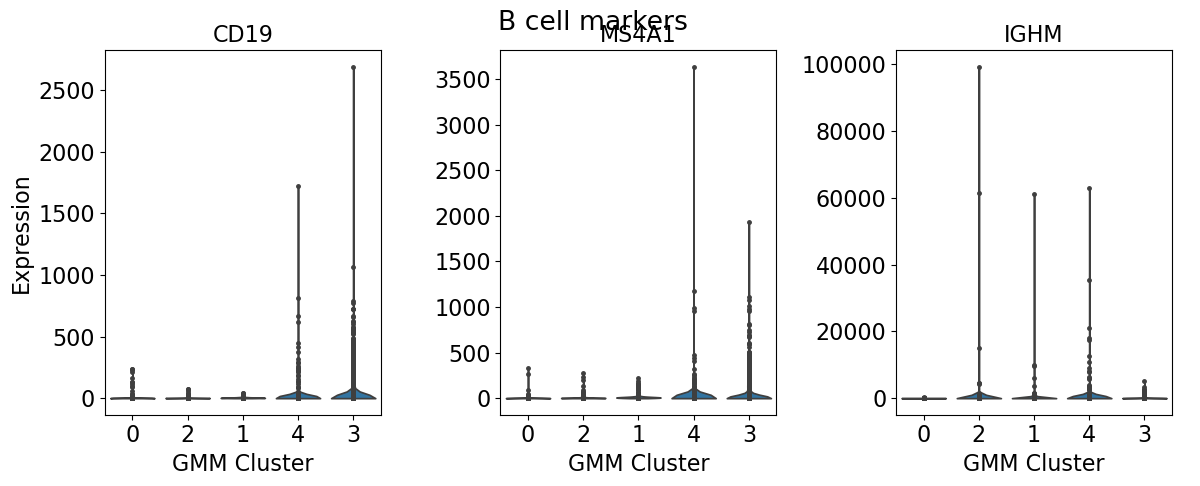

In [417]:
# Add GMM cluster labels to adata.obs
adata.obs['GMM_cluster'] = labels.astype(str)  # convert to string for better plotting

# List of gene IDs to plot
genes = ['CD19', 'MS4A1', 'IGHM']

# Create long-format dataframe for seaborn
plot_data = pd.DataFrame({
    'GMM_cluster': adata.obs['GMM_cluster']
})

# Add gene expression per cell
for gene in genes:
    plot_data[gene] = protein[:, gene].X.toarray().flatten() if hasattr(protein[:, gene].X, 'toarray') else protein[:, gene].X.flatten()

# Melt for long format
long_df = plot_data.melt(id_vars='GMM_cluster', value_vars=genes, var_name='Gene', value_name='Expression')

# Use seaborn catplot to facet by gene
g = sns.catplot(
    data=long_df,
    x='GMM_cluster',
    y='Expression',
    col='Gene',
    kind='violin',
    inner='point',
    cut=0,
    density_norm='width',
    height=5,
    aspect=0.8,
    sharey=False  # optional: allows each gene to have its own y-axis scale
)

g.set_titles(col_template='{col_name}')
g.set_axis_labels('GMM Cluster', 'Expression')

for ax in g.axes.flat:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
plt.suptitle('B cell markers')
plt.show()

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


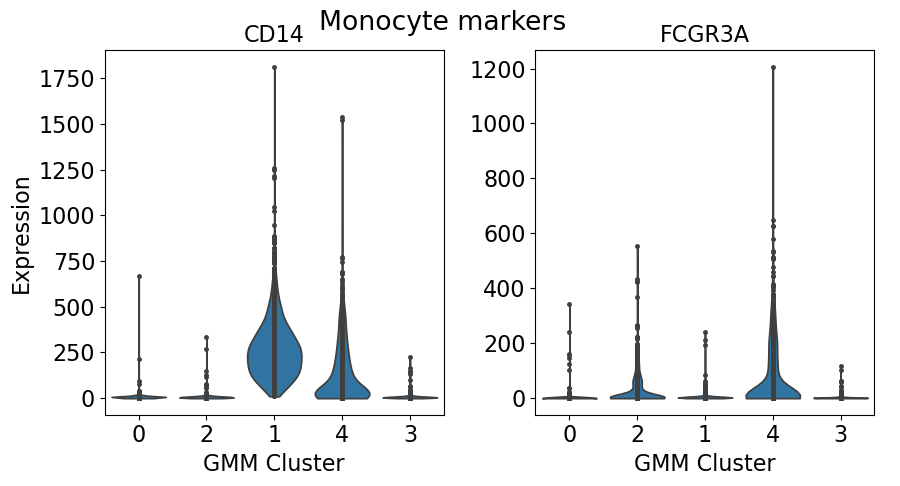

In [418]:
# List of gene IDs to plot
genes = ['CD14', 'FCGR3A']

# Create long-format dataframe for seaborn
plot_data = pd.DataFrame({
    'GMM_cluster': adata.obs['GMM_cluster']
})

# Add gene expression per cell
for gene in genes:
    plot_data[gene] = protein[:, gene].X.toarray().flatten() if hasattr(protein[:, gene].X, 'toarray') else protein[:, gene].X.flatten()

# Melt for long format
long_df = plot_data.melt(id_vars='GMM_cluster', value_vars=genes, var_name='Gene', value_name='Expression')

# Use seaborn catplot to facet by gene
g = sns.catplot(
    data=long_df,
    x='GMM_cluster',
    y='Expression',
    col='Gene',
    kind='violin',
    inner='point',
    cut=0,
    density_norm='width',
    height=5,
    aspect=0.9,
    sharey=False  # optional: allows each gene to have its own y-axis scale
)

g.set_titles(col_template='{col_name}')
g.set_axis_labels('GMM Cluster', 'Expression')

for ax in g.axes.flat:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
plt.suptitle('Monocyte markers')
plt.show()

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


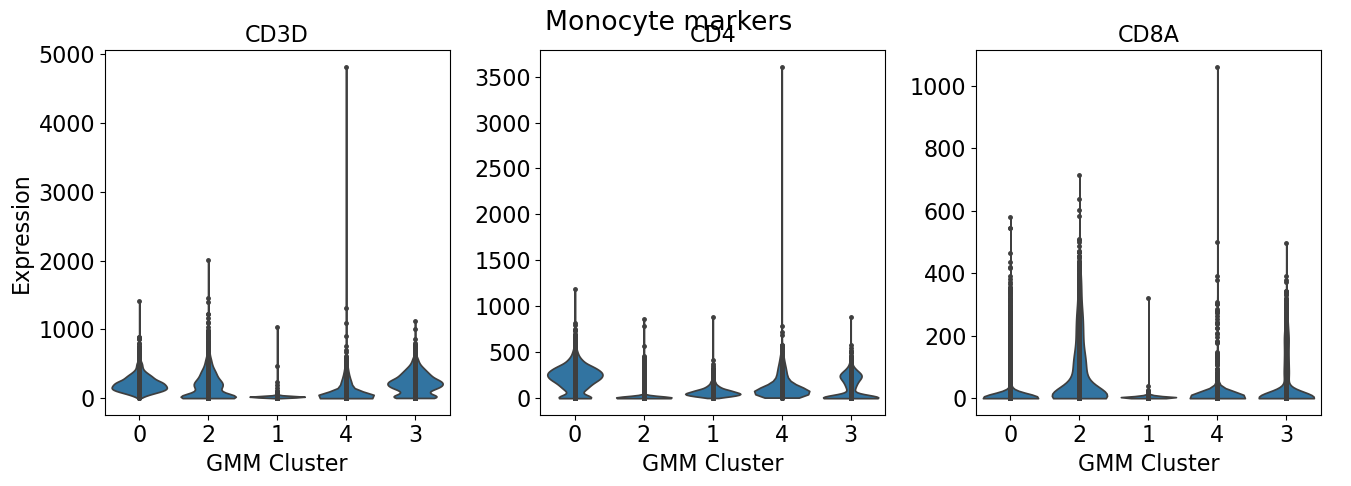

In [419]:
# List of gene IDs to plot
genes = ['CD3D','CD4', 'CD8A']

# Create long-format dataframe for seaborn
plot_data = pd.DataFrame({
    'GMM_cluster': adata.obs['GMM_cluster']
})

# Add gene expression per cell
for gene in genes:
    plot_data[gene] = protein[:, gene].X.toarray().flatten() if hasattr(protein[:, gene].X, 'toarray') else protein[:, gene].X.flatten()

# Melt for long format
long_df = plot_data.melt(id_vars='GMM_cluster', value_vars=genes, var_name='Gene', value_name='Expression')

# Use seaborn catplot to facet by gene
g = sns.catplot(
    data=long_df,
    x='GMM_cluster',
    y='Expression',
    col='Gene',
    kind='violin',
    inner='point',
    cut=0,
    density_norm='width',
    height=5,
    aspect=0.9,
    sharey=False  # optional: allows each gene to have its own y-axis scale
)

g.set_titles(col_template='{col_name}')
g.set_axis_labels('GMM Cluster', 'Expression')

for ax in g.axes.flat:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
plt.suptitle('Monocyte markers')
plt.show()

# Check covariance relationships

In [131]:
min_mean = 1
s = 0.36

idx = (adata.layers["mature"].toarray().mean(0) > min_mean) & (adata.layers["nascent"].toarray().mean(0) > 0.1*min_mean)

U = adata.layers["nascent"][:,idx].toarray()
S = adata.layers["mature"][:,idx].toarray()

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)

S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_uu = ((U_var-U_mean)/U_mean**2-s)/(1+s)
zeta_ss = ((S_var-S_mean)/S_mean**2-s)/(1+s)

cov_us = []
for i in np.arange(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
cov_us = np.array(cov_us)
zeta_us = ((cov_us)/S_mean/U_mean-s)/(1+s)
zeta_us.shape

(3,)

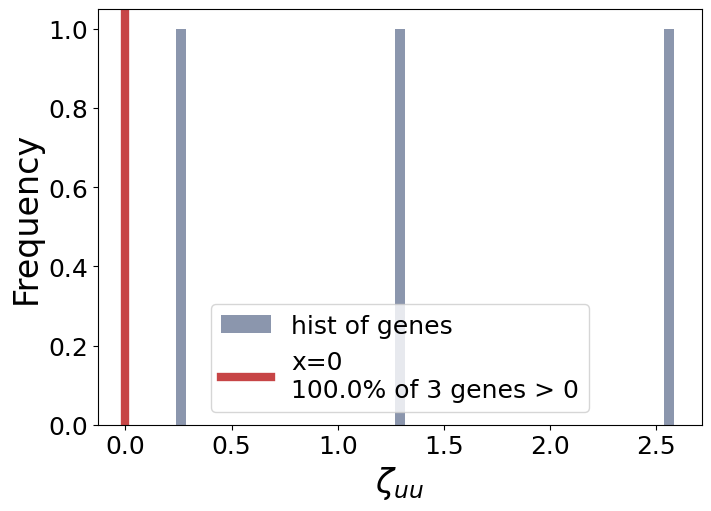

In [132]:
plt.figure(figsize=(7,5))
plt.hist(zeta_uu,bins=50,color=gray,label='hist of genes');
#plt.text(1.5, 300, str(np.around(100*(zeta_uu>0).mean(),2))+'% of '+str(len(zeta_uu))+' genes > 0', color='k')
plt.axvline(x=0,c=red,label='x=0\n'+str(np.around(100*np.array(zeta_uu>0).mean(),2))+'% of '+str(len(zeta_uu))+' genes > 0')
plt.xlabel(r'$\zeta_{uu}$',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.legend();
plt.savefig(figprefix+"_uu.pdf", dpi=150)

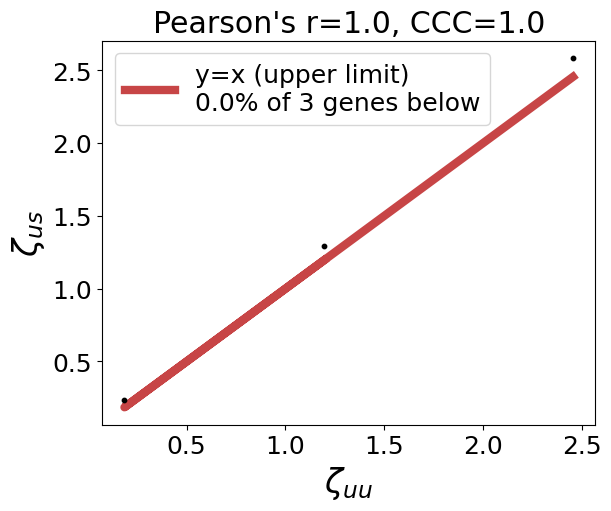

In [133]:
x=zeta_us
y=zeta_uu

plt.figure(figsize=(6,5))
plt.plot(x,x,zorder=0,c=red, \
         label='y=x (upper limit)\n' \
         +str(np.around(100*(x>y).mean(),2))+'% of '+str(len(zeta_uu))+' genes below')
#plt.text(0, 5, str(np.around(100*(x>y).mean(),2))+'% of '+str(len(zeta_uu))+r' genes $\zeta_{uu}>\zeta_{us}$', color='k')
#plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,color=dark)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
#plt.colorbar(label='1/mean')
plt.legend()
plt.xlabel(r'$\zeta_{uu}$',fontsize=label_font)
plt.ylabel(r'$\zeta_{us}$',fontsize=label_font)
plt.savefig(figprefix+"_us.pdf", dpi=150)

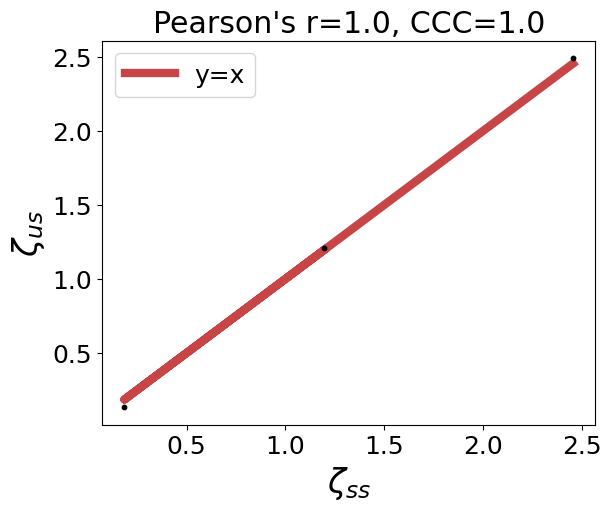

In [134]:
x=zeta_us
y=zeta_ss

plt.figure(figsize=(6,5))
plt.plot(x,x,zorder=0,label='y=x',c=red)
plt.scatter(x,y,s=10,color=dark)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
#plt.colorbar(label=r'1/E[$N_s$]')
#plt.text(1, 2, "CCC = "+str(np.round(CCC(x,y),2)), fontsize=24, color='k')
plt.legend()
plt.xlabel(r'$\zeta_{ss}$',fontsize=label_font)
plt.ylabel(r'$\zeta_{us}$',fontsize=label_font)
plt.savefig(figprefix+"_ss.pdf", dpi=150)

In [73]:
U = adata.layers["nascent"].toarray()[:,protein_gene_rna_idx]
S = adata.layers["mature"].toarray()[:,protein_gene_rna_idx]
P = protein.X
U.shape, P.shape

((8457, 119), (8457, 119))

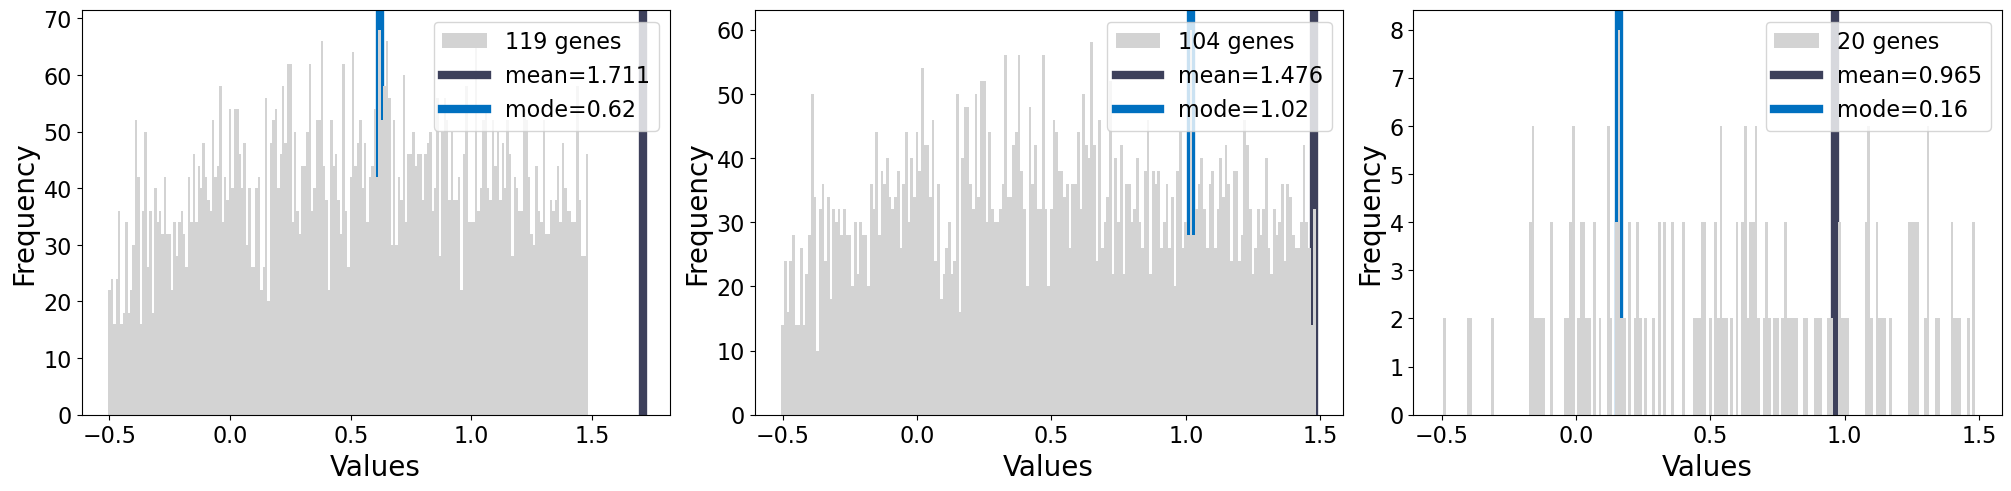

In [25]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s_mm = estimate_s(N1=P,ax=axs[0],min_mean=0)
s_nn = estimate_s(N1=P,ax=axs[1],min_mean=10)
s_nn = estimate_s(N1=P,ax=axs[2],min_mean=100)

for i in range(3):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

In [74]:
s = 0

iidx = (np.mean(P,axis=0)>0) & (np.mean(S,axis=0)>0)
U = U[:,iidx]
S = S[:,iidx]
P = P[:,iidx]

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
P_mean = np.mean(P,axis=0)
P_var = np.var(P,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_pp = (P_var-P_mean)/P_mean**2-s
zeta_uu = (U_var-U_mean)/U_mean**2-s
zeta_ss = (S_var-S_mean)/S_mean**2-s

cov_us = []
cov_up = []
cov_sp = []
for i in range(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
    cov_up.append(np.cov(U[:,i],P[:,i])[0,1])
    cov_sp.append(np.cov(S[:,i],P[:,i])[0,1])
    
zeta_us = (np.array(cov_us)/U_mean/S_mean)-s
zeta_up = (np.array(cov_up)/U_mean/P_mean)-s
zeta_sp = (np.array(cov_sp)/S_mean/P_mean)-s
zeta_us

/tmp/ipykernel_4139686/252965508.py:16: RuntimeWarning: invalid value encountered in divide
  zeta_uu = (U_var-U_mean)/U_mean**2-s
/tmp/ipykernel_4139686/252965508.py:27: RuntimeWarning: invalid value encountered in divide
  zeta_us = (np.array(cov_us)/U_mean/S_mean)-s
/tmp/ipykernel_4139686/252965508.py:28: RuntimeWarning: invalid value encountered in divide
  zeta_up = (np.array(cov_up)/U_mean/P_mean)-s


array([ 6.04903735e-01, -1.00011827e+00,  9.31864150e-01, -1.00011829e+00,
                   nan,  5.16059930e-01,  4.27104778e+01,             nan,
        5.10414836e+00,  1.21107740e+00,             nan,  1.48318830e+00,
        2.21476851e+00,  9.54601681e+00,             nan,             nan,
        6.43483265e+00,  4.08893114e+00,  1.54017041e+00,  1.10590872e+00,
                   nan,  1.04995419e+01,  1.58484883e+01,  4.06996563e+00,
                   nan,  2.70195360e+00,  2.19423171e+00,  1.73981780e+00,
        1.00215388e+00,  2.65544161e-01,             nan,  6.39430399e-01,
        5.67085996e+01,  8.00284092e+02, -1.00011824e+00,  4.30187173e+00,
        4.57413477e+00,  1.34828918e+00,  1.90441473e+00,  1.33199734e+00,
        1.09253146e+02, -1.00011825e+00,  4.55304162e-01,  1.66084928e+00,
                   nan,  2.06141425e+00, -1.00011827e+00,  2.20822693e+00,
        5.09793537e+00,             nan,             nan, -1.00011828e+00,
        2.59881698e+00,  

## $Cov(N_u,N_p)$ 
$$ \gamma_p \zeta_{us} = (\gamma_p + \beta) \zeta_{up} $$  

In [75]:
zeta_up,zeta_us

(array([ 1.76854319e-01,  1.99733624e+00,  6.63440172e-01,  1.01450903e+01,
                    nan,  6.32817612e-01,  7.77837752e-01,             nan,
         3.03595192e+00,  1.54492732e+00,             nan, -3.64419331e-01,
         1.61653467e+00,  7.09271738e+00,             nan,             nan,
        -9.56542789e-01,  1.04803948e+01,  5.32128125e-01,  1.24782719e+00,
                    nan,  8.33445440e-01,  2.57561603e+01,  2.67569724e+00,
                    nan,  6.94609267e-01,  1.57284371e+00,  1.32003336e+00,
         6.49796974e-01,  1.01277953e+00,             nan,  1.16012784e-01,
         1.89945142e+01,  7.98974288e+01, -6.81231468e-03,  2.67662303e+00,
         2.83917227e+00,  9.34771569e-01,  8.11862137e-03, -1.19751535e-01,
         2.81560919e+00,  4.45099079e-01,  3.42370672e-01,  1.50430475e+00,
                    nan,  9.85119129e-01,  1.40549513e+01,  1.10679122e+00,
         1.08214338e+00,             nan,             nan,  1.32752764e+00,
         1.8

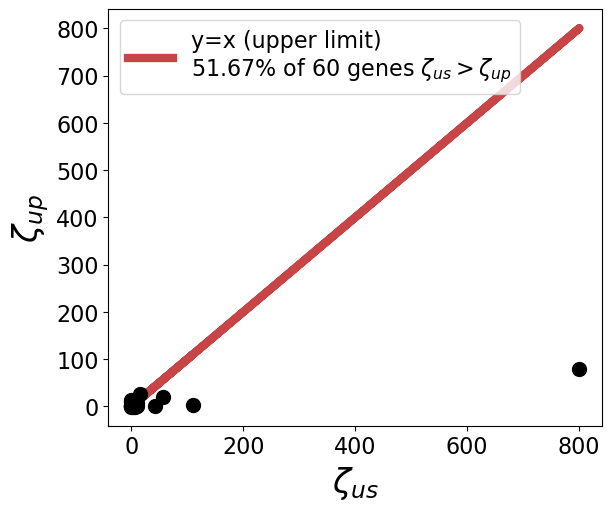

In [76]:
x=zeta_us
y=zeta_up

plt.figure(figsize=(6,5))
plt.plot(x,x,zorder=0,c=red, \
         label='y=x (upper limit)\n'+str(np.around(100*(x>y).mean(),2))+'% of '+str(len(zeta_uu))+r' genes $\zeta_{us}>\zeta_{up}$')
#plt.text(0, 10, str(np.around(100*(x>y).mean(),2))+'% of '+str(len(zeta_uu))+r' genes $\zeta_{uu}>\zeta_{us}$', color='k')
#plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=100,color=dark)
#plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
#plt.colorbar(label='1/mean')
plt.legend(loc='upper left')
plt.xlabel(r'$\zeta_{us}$',fontsize=label_font)
plt.ylabel(r'$\zeta_{up}$',fontsize=label_font)
plt.savefig(figprefix+"_up.pdf", dpi=150)

## $Cov(N_s,N_p)$ 

$$\gamma (\zeta_{up}-\zeta_{sp}) + \gamma_p (\zeta_{ss}-\zeta_{sp}) = -\frac{\gamma_p}{\overline{X_s}} $$

In [77]:
zeta_up-zeta_sp,(zeta_ss-zeta_sp)

(array([-3.35123053e-01, -3.01497745e-01,  3.49176204e-01,  5.41734986e+00,
                    nan, -2.07649425e-01, -1.01614382e+01,             nan,
         6.55215195e-01, -7.88515874e-01,             nan, -7.29956701e-01,
         9.09900768e-01,  4.80569029e+00,             nan,             nan,
        -6.57677147e-01,  7.03786221e+00, -6.10658364e-01,  2.10763716e-01,
                    nan, -3.27978373e-02,  8.52078286e-01,  6.43786473e-01,
                    nan, -1.56337717e+00, -7.70439140e-01, -7.24949613e-01,
         3.02199604e-02, -2.82502290e-01,             nan, -5.44568848e-01,
         8.42938433e+00, -1.63506782e+01, -2.54782967e+00,  2.64799872e-02,
        -7.77344799e-01, -2.23090949e-02, -1.25746221e+00, -6.02561651e-01,
        -4.58286320e+00, -3.21164755e+01, -1.32691888e-01,  2.42981966e-01,
                    nan, -3.26160666e-01,  3.95777603e+00, -1.32792839e+00,
        -1.48780103e+00,             nan,             nan, -1.89492099e+00,
         9.8

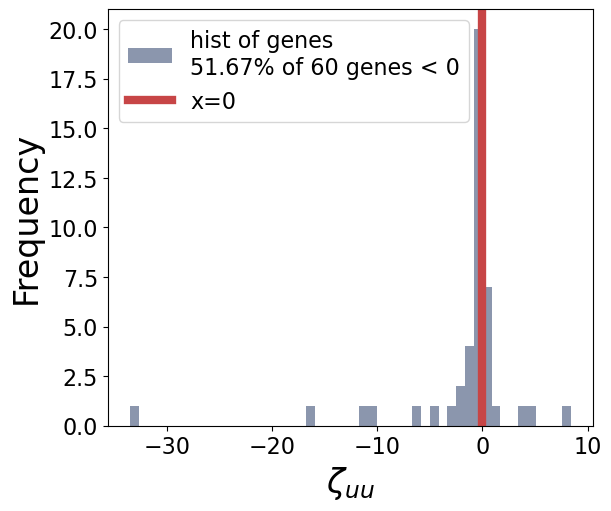

In [78]:
x = np.minimum(zeta_up-zeta_sp,zeta_ss-zeta_sp)

plt.figure(figsize=(6,5))
plt.hist(x,bins=50,color=gray,\
         label='hist of genes\n' + str(np.around(100*(x<0).mean(),2))+'% of '+str(len(zeta_uu))+' genes < 0')
plt.axvline(x=0,c=red,label='x=0')
plt.xlabel(r'$\zeta_{uu}$',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.legend();
plt.savefig(figprefix+"_sp.pdf", dpi=150)

## $Var(N_p)$ 
$$ \zeta_{sp} = \zeta_{pp} $$  

In [30]:
lower_bound, upper_bound, delta_eta_bootstrap = bootstrapping_func(delta_eta,[S,P],B=1000,n_cores=50)
Null_gene_mask = (0 < upper_bound) & (0 > lower_bound) 
Null_gene_mask.mean()


00%|██████████| 1000/1000 [00:00<00:00, 3328812.70it/s]

0.0625

Pearson's r=0.634, CCC=0.601


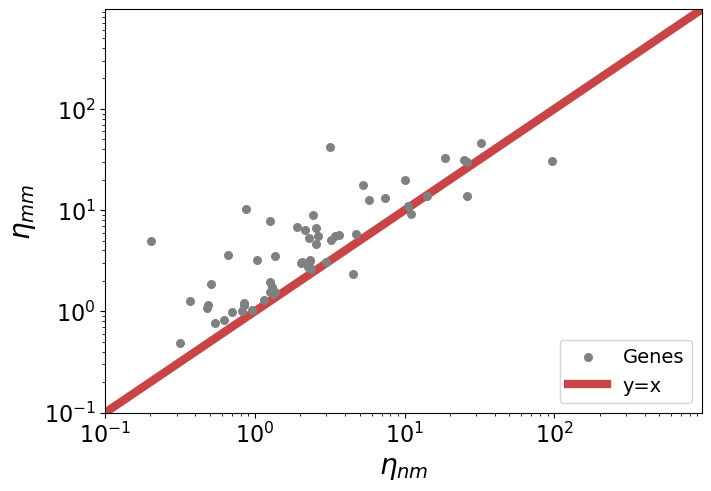

In [80]:
x=zeta_sp
y=zeta_pp

all_data = np.concatenate([x, y])
min_val, max_val = 1e-1, all_data.max()*10

plt.figure(figsize=(7,4.8))
#plt.scatter(x[Null_gene_mask],y[Null_gene_mask],s=30,zorder=2,color='gray',label='Compliant genes\n('+str(np.around(100*np.mean(Null_gene_mask),1))+"%)")
plt.scatter(x,y,s=30,color='gray',zorder=1,label='Genes')
plt.loglog([min_val, max_val],[min_val, max_val],zorder=0,c=red,label='y=x')
plt.legend(loc='lower right',fontsize=14);
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.xlabel(r'$\eta_{nm}$',fontsize=20);
plt.ylabel(r'$\eta_{mm}$',fontsize=20);
#plt.savefig(figprefix+"_us.pdf", dpi=150)
print("Pearson's r="+str(np.round(pearsonr(x,y).statistic,3))+", CCC="+str(np.round(CCC(x,y),3)))